In [1]:
import pandas as pd
import os
from pathlib import Path
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import seaborn as sns

Fontconfig error: Cannot load default config file: No such file: (null)


In [16]:
DL = ['DenseNet201', 'MobileNetV2', 'InceptionV3', "ResNet50"]
ML = ['GradientBoosting', 'KNN', 'NBayes', "RandomForest"]
COLUMNS = ["val_accuracy", "val_precision", "val_specificity", "val_f1_score", "val_auc", "val_sensitivity"]
SUBSETS = ['Dataset01_100', 'Dataset01_95.0', 'Dataset01_90.0', 'Dataset01_85.0', 'Dataset01_80.0', 'Dataset01_75.0', 
           'Dataset01_70.0', 'Dataset01_65.0', 'Dataset01_60.0', 'Dataset01_55.0', 'Dataset01_50.0', 'Dataset01_45.0',
           'Dataset01_40.0', 'Dataset01_35.0', 'Dataset01_30.0', 'Dataset01_25.0', 'Dataset01_20.0', 'Dataset01_15.0', 
           'Dataset01_10.0', 'Dataset01_5.0']


In [17]:
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

output = results_path / "analitycs" / "by_test"

In [18]:
import pandas as pd
import os
from pathlib import Path

# Define paths
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

# DataFrame to hold all results
all_results = []

# Process each network and subset
for network in DL + ML:
    for subset in SUBSETS:
        # Define the path for CSV files
        metrics_path = results_path / subset / network / "metrics"
        if network in DL:
            csvs_path = metrics_path / "csvs" / '_refined'
        else:
            csvs_path = metrics_path
        
        # List all files in the directory
        if csvs_path.exists() and csvs_path.is_dir():
            csv_files = [f for f in csvs_path.iterdir() if f.is_file()]
            
            # Read each file and append to the list
            for csv_file in csv_files:
                
                try:
                    df = pd.read_csv(csv_file)
                    
                    df['Model'] = network
                    df['Subset'] = subset
                    if str(csv_file).split("/")[-1].split(".")[0].endswith("f"):
                       df['dataset'] = df["dataset"].apply(lambda x: x.split("_")[1]).astype(float)
                    all_results.append(df)
                except Exception as e:
                    print(f"Error reading {csv_file}: {e}")



# Concatenate all DataFrames
result = pd.concat(all_results, ignore_index=True)
result.to_csv("all_results.csv", index=False)
result.head()



#drop nan in dataset column and how many nan we have


print(result['dataset'].unique())

[100.  95.  90.  85.  80.  75.  70.  65.  60.  55.  50.  45.  40.  35.
  30.  25.  20.  15.  10.   5.]


In [19]:
#  Análise estatística (teste de hipótese)
#  hipotese: quero provar que a variação das ROI's influencia no desempenho e métricas dos modelos de redes neurais
#  hipotese nula (H0): as métricas de desempenho dos modelos de redes neurais são iguais entre cada subconjunto de dados (SUBSETS -> ROIS)
#  hipotese alternativa (H1): as métricas de desempenho dos modelos de redes neurais são diferentes entre cada subconjunto de dados (SUBSETS -> ROIS)
# alpha = 0.01, 1% de significância, de concluir que a hipótese nula é falsa quando ela é verdadeira.
# Valor-p (p-value)
## Se p-value < alpha: rejeita-se a hipótese nula (temos evidências suficientes para rejeitar a hipótese nula) (0) (green)
## Se p-value >= alpha: não rejeita-se a hipótese nula (não temos evidências suficientes para rejeitar a hipótese nula) (1) (red)
# Teste de hipótese: ranksums (teste de Mann-Whitney)



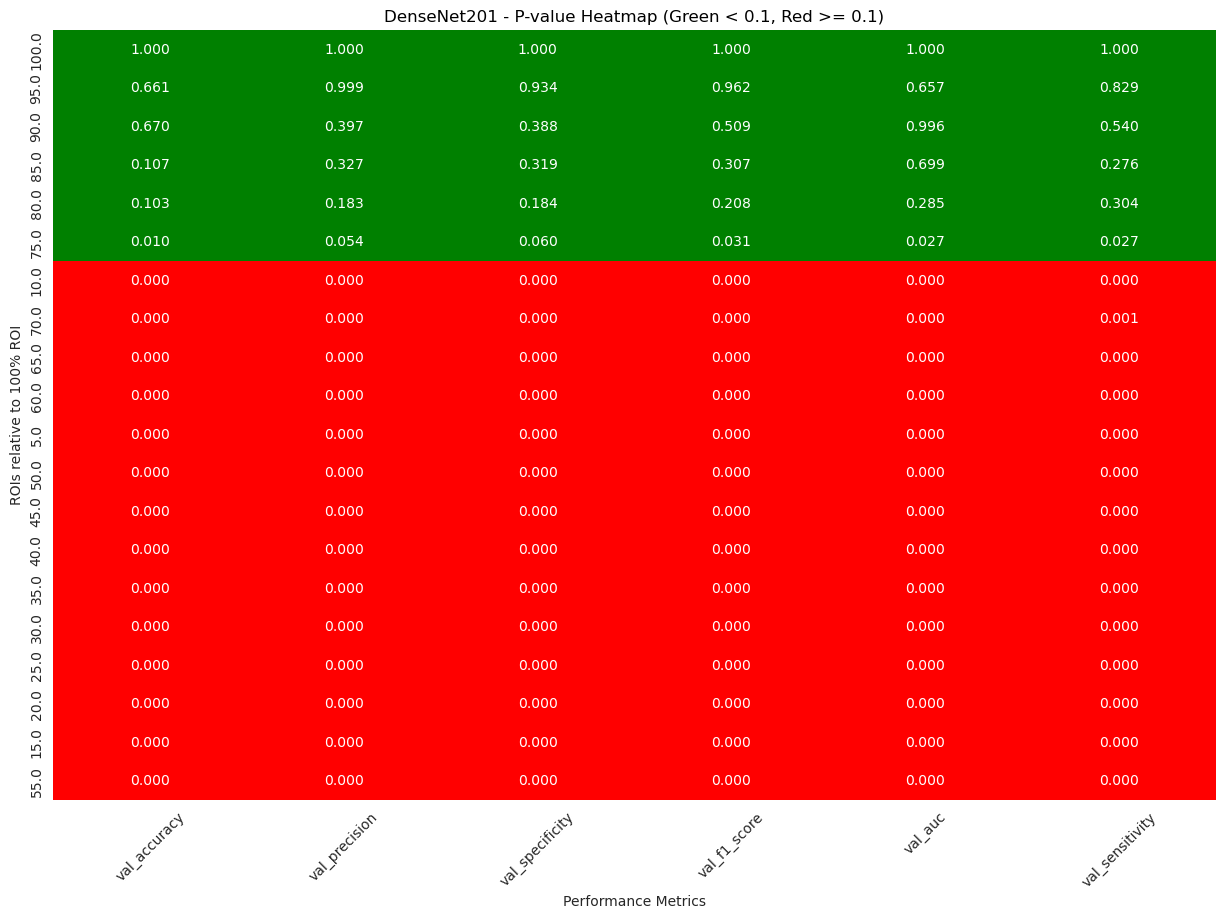

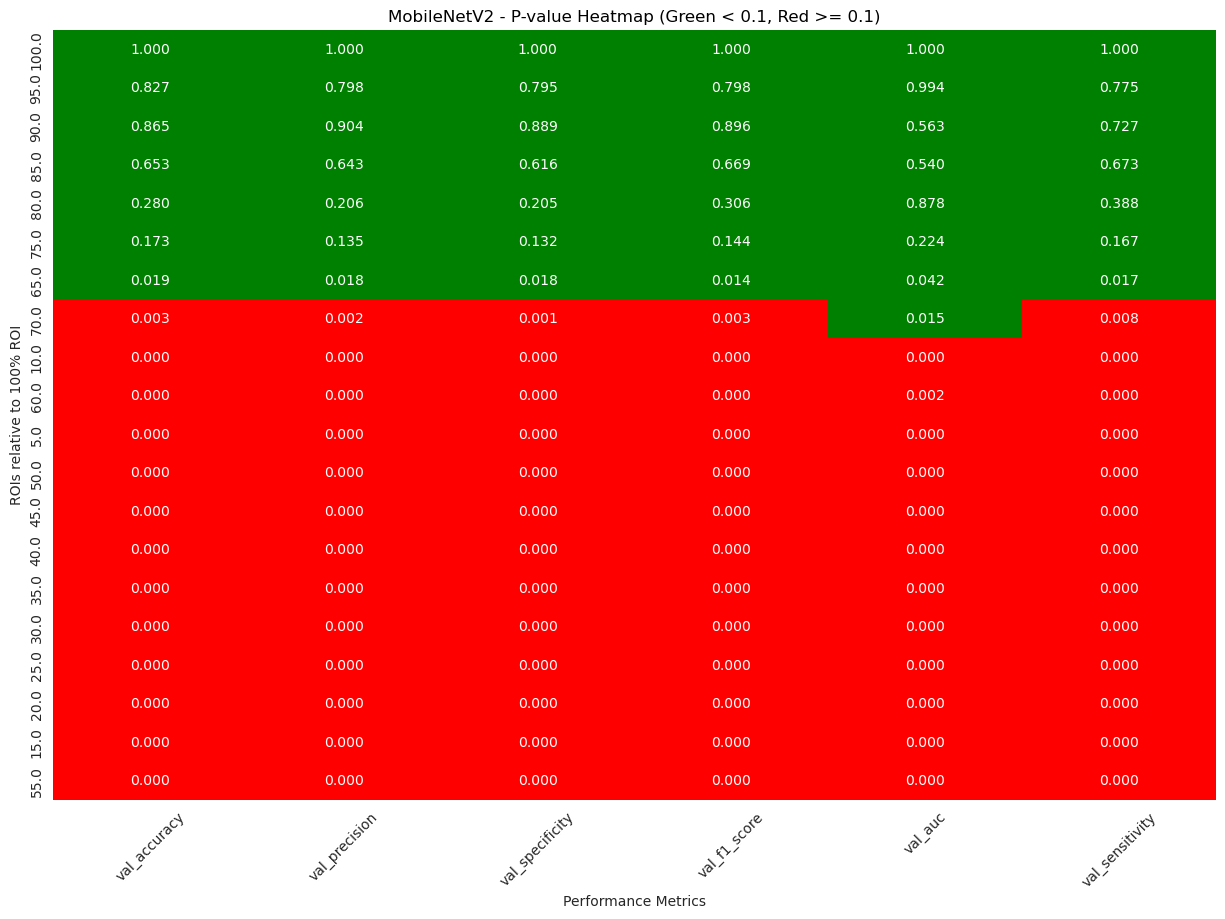

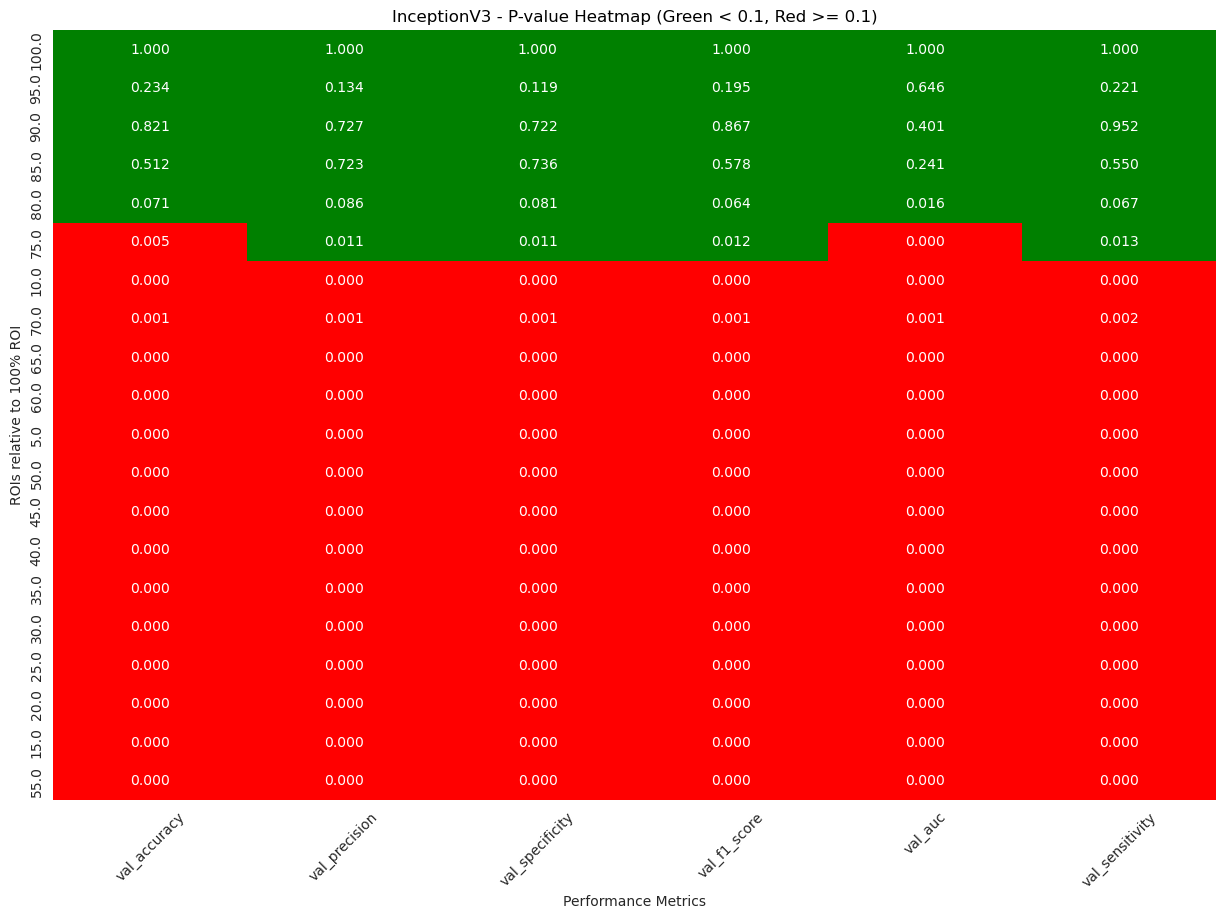

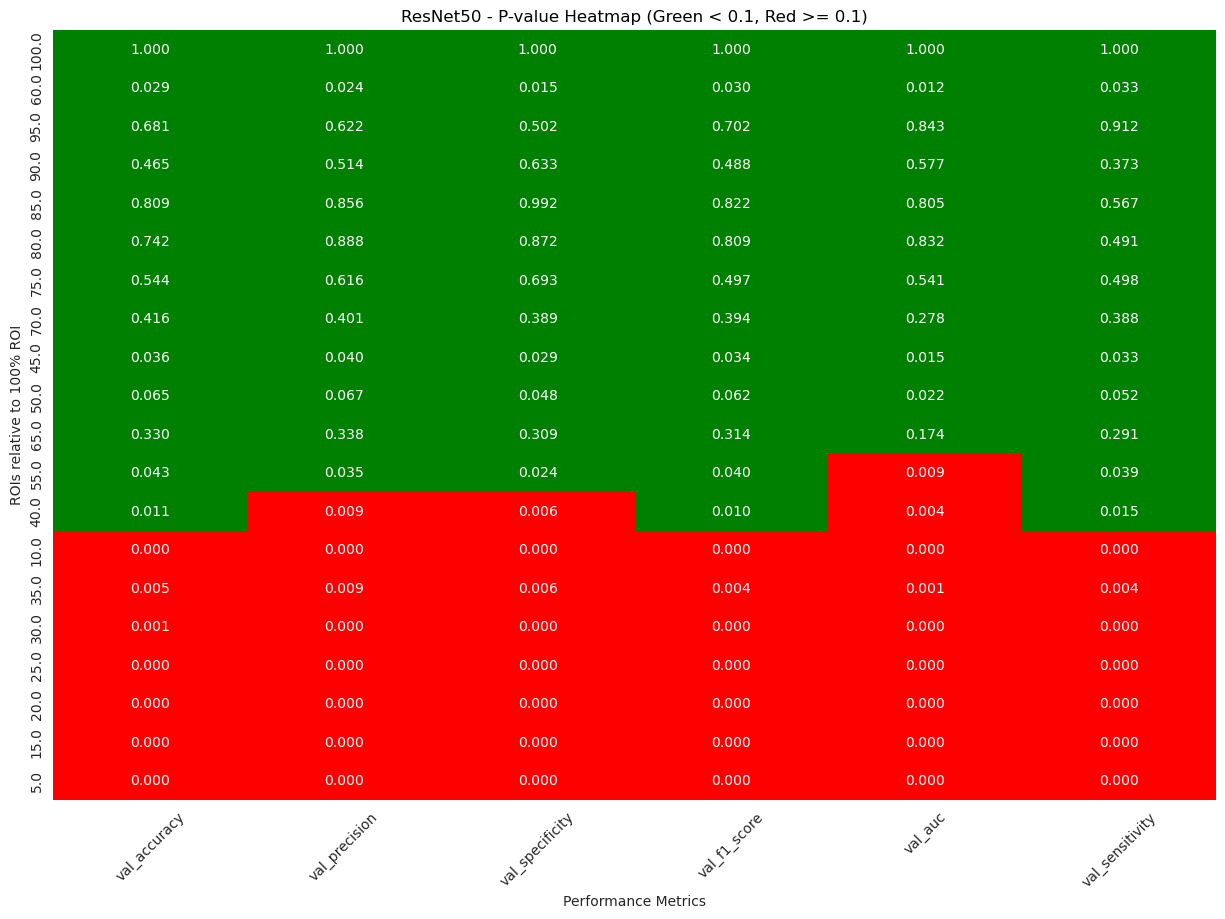

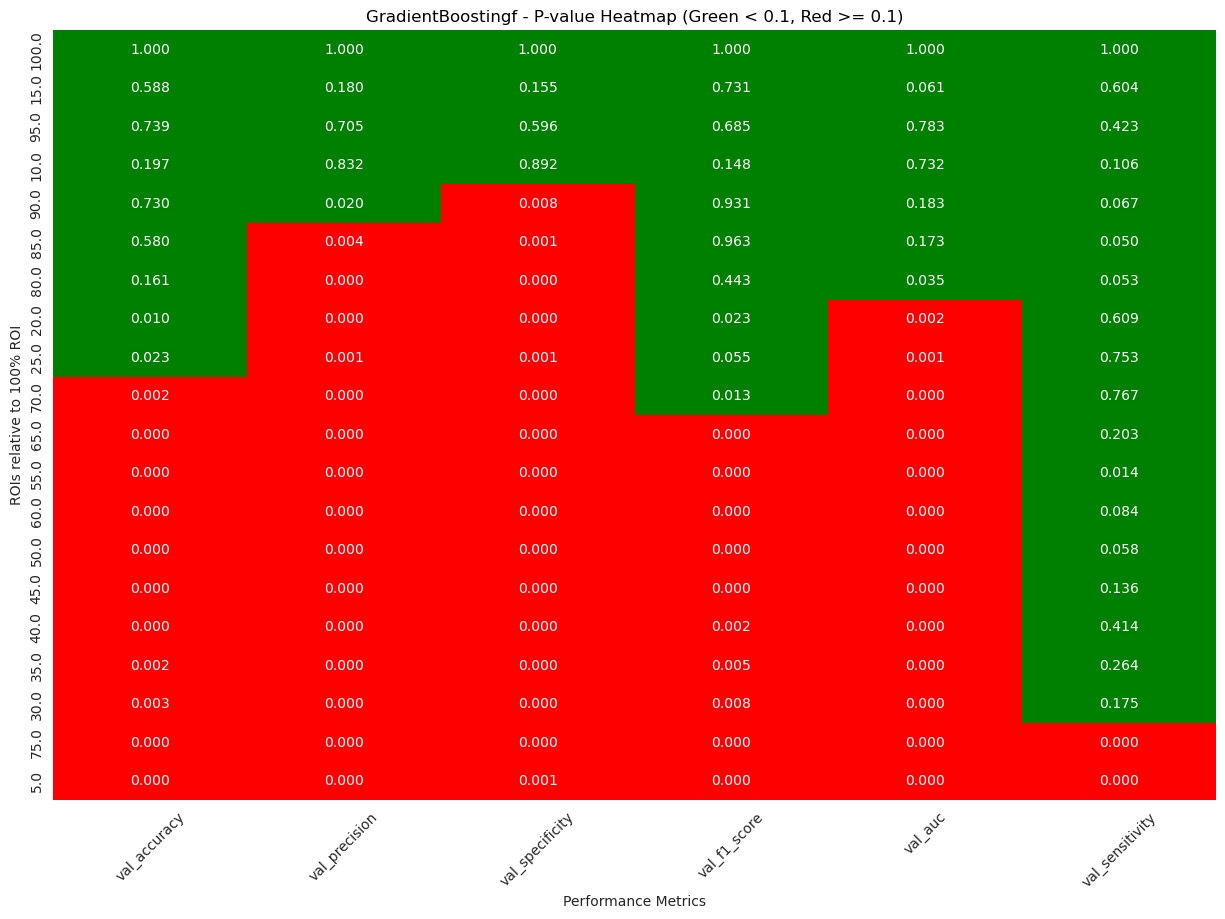

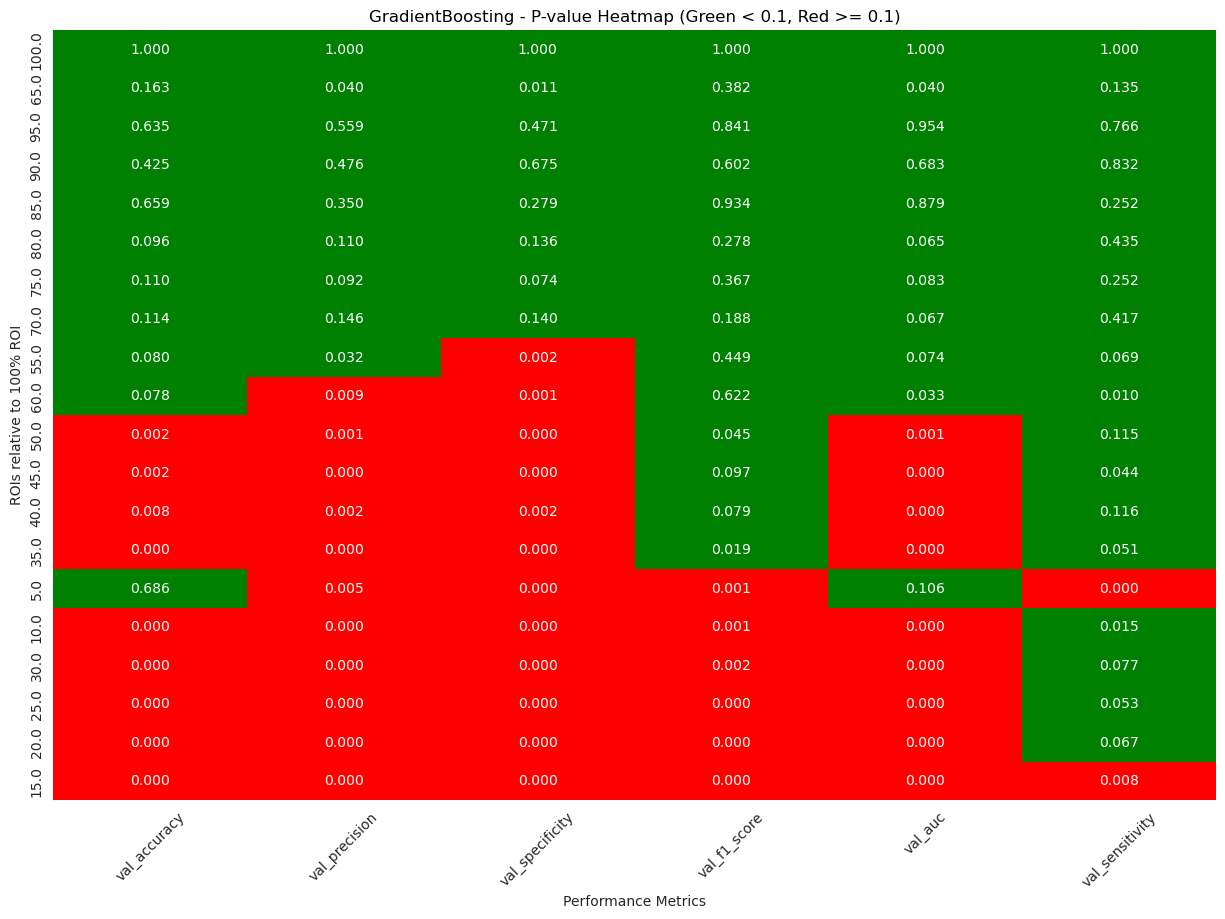

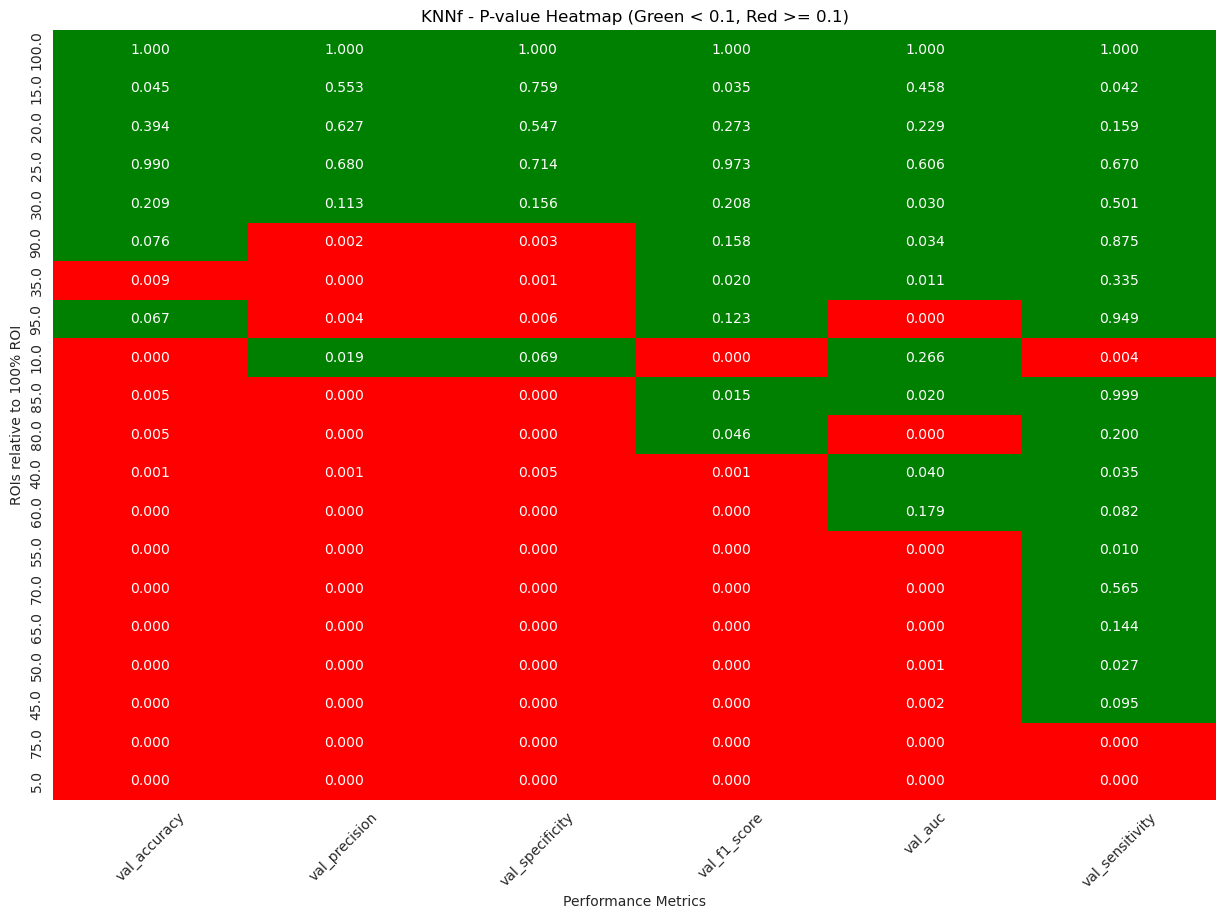

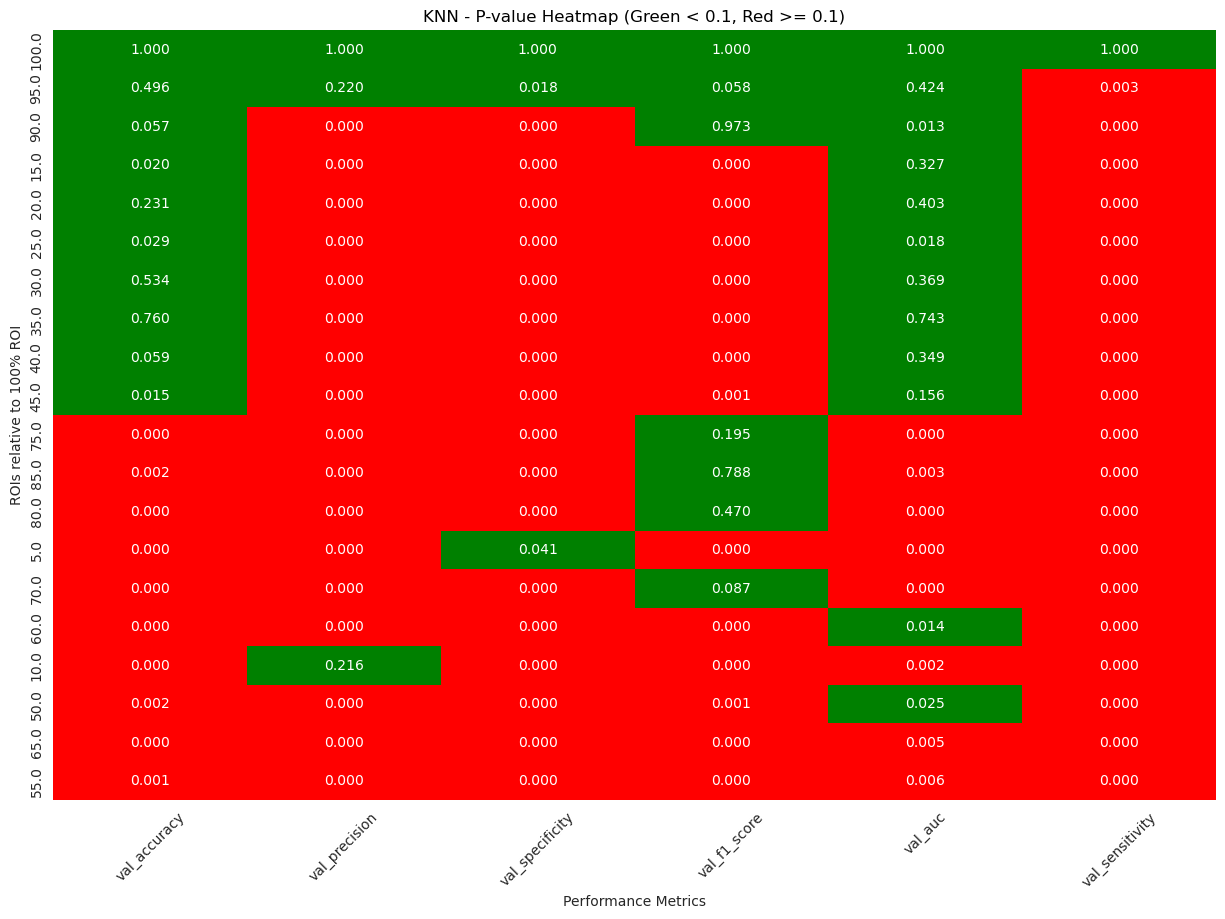

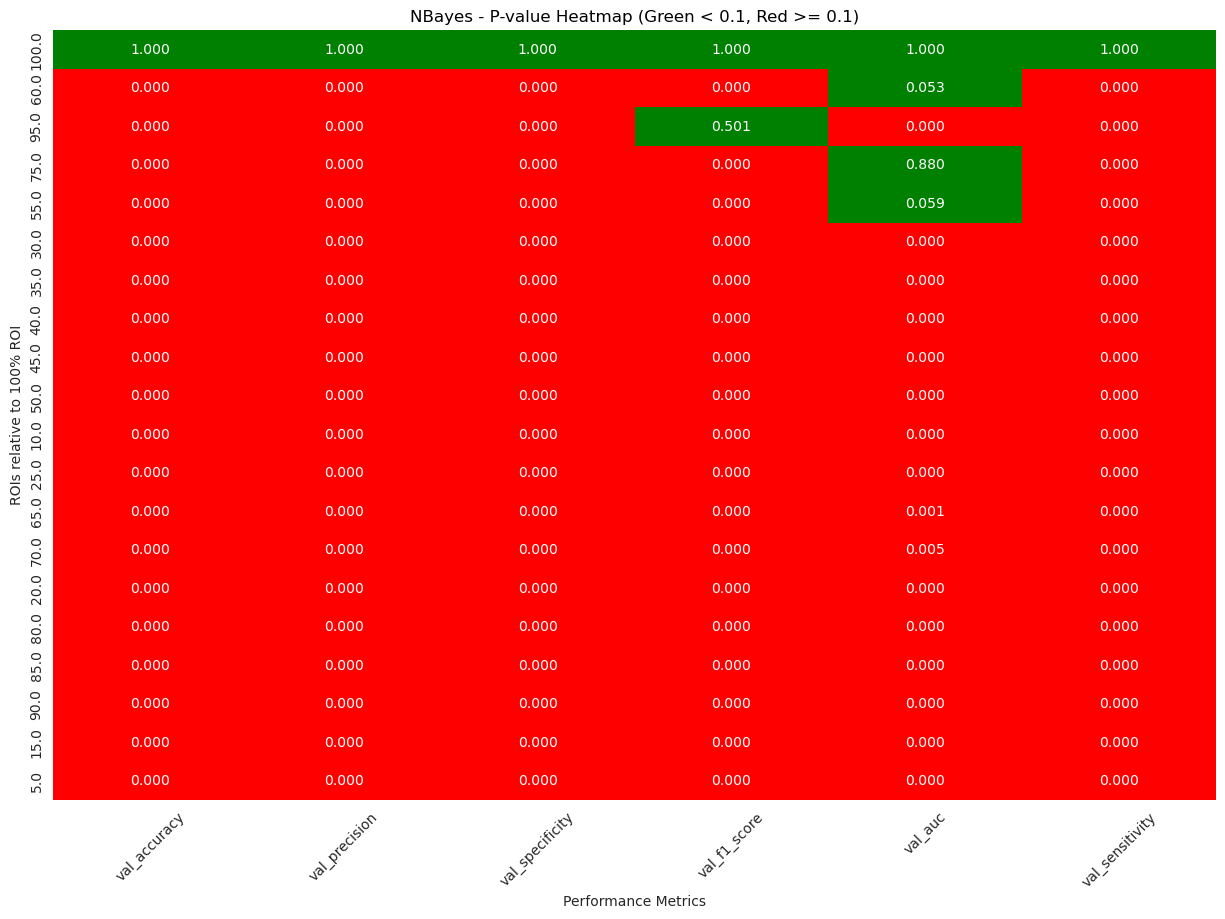

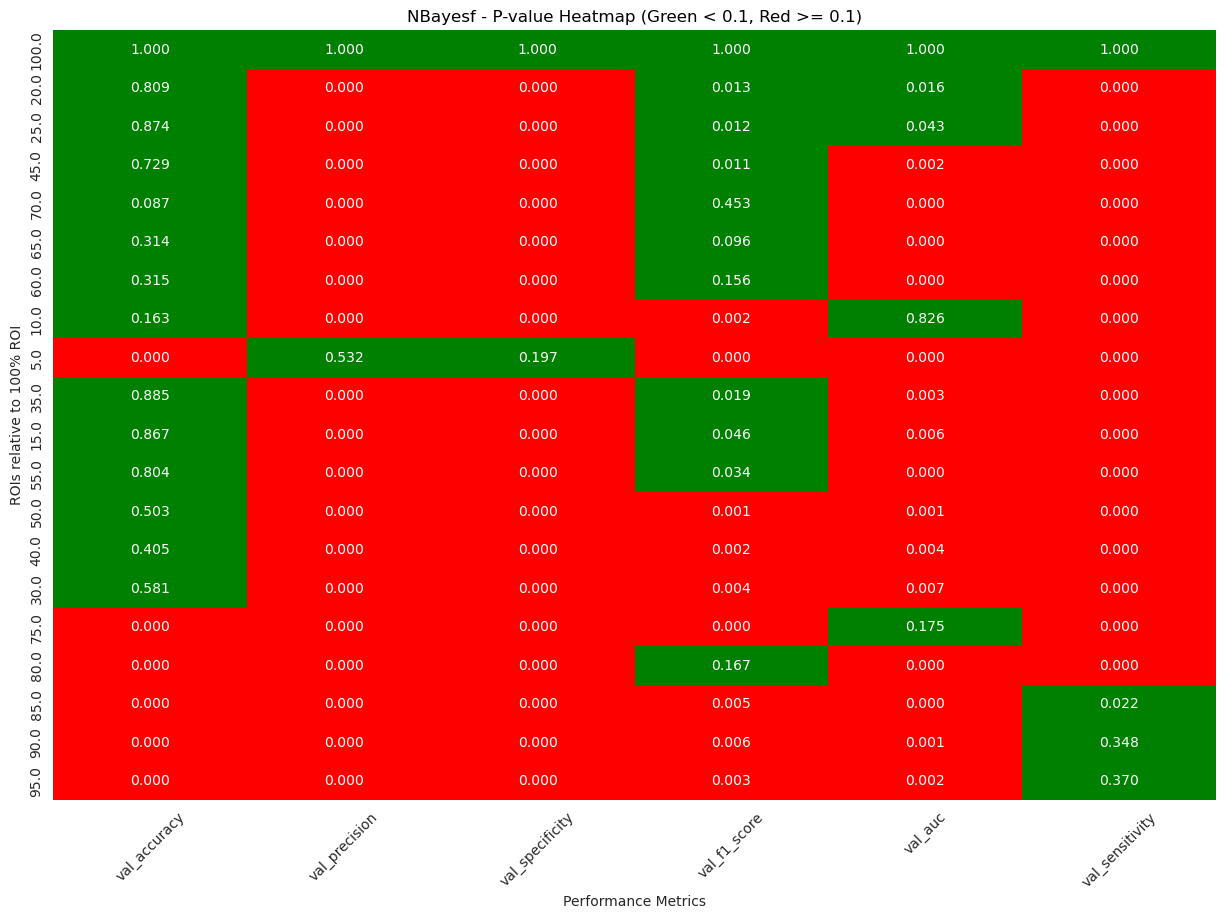

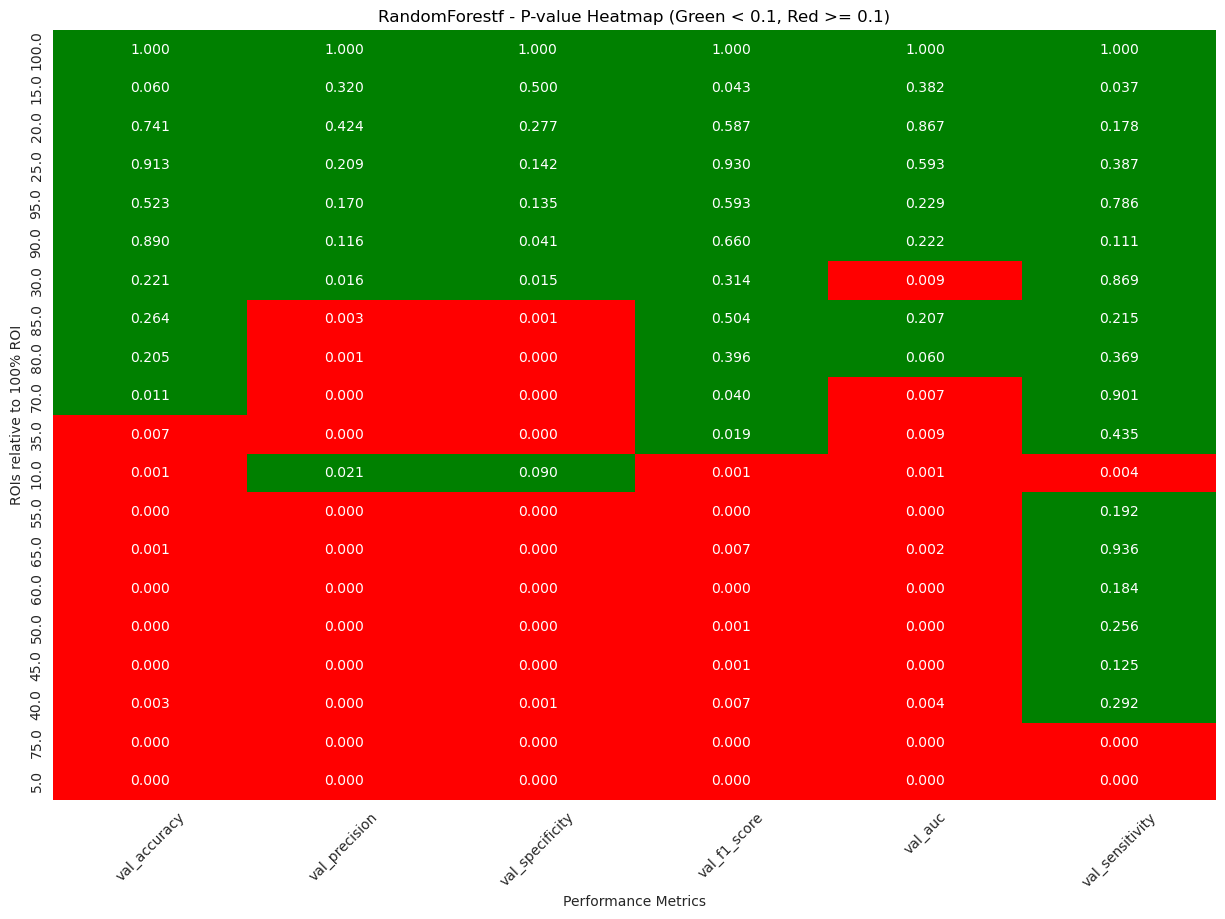

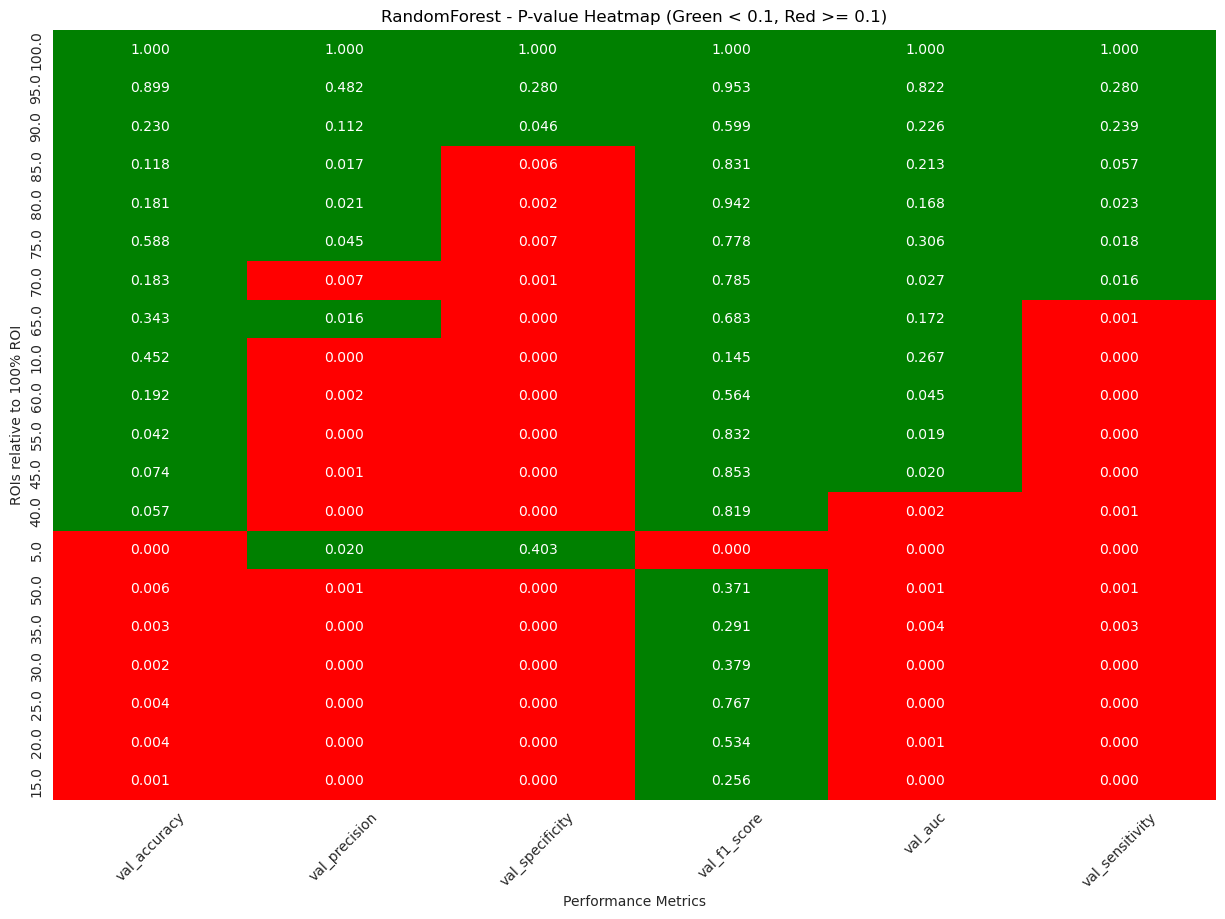

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.stats import ranksums
from matplotlib.colors import ListedColormap

# Função para testar a hipótese
def test_hyphotesis(main_pd, roi, alpha=0.01):
    normalized_values = pd.DataFrame()
    for network in main_pd['network'].unique():
        network_data = main_pd[main_pd['network'] == network]
        roi_data = network_data[network_data['dataset'] == roi]
       
        # Avaliando todas as métricas
        for column in COLUMNS:
            # Comparação com 100% de ROI
            p_value = ranksums(roi_data[column], network_data[network_data['dataset'] == 100][column], alternative='two-sided').pvalue
            h = 0 if p_value < alpha else 1
            normalized_values = normalized_values._append({'network': network, 'roi': roi, 'column': column, 'p_value': p_value, 'h': h}, ignore_index=True)
        
    return normalized_values

# Aplicação da função e geração do CSV
result_p_values = pd.DataFrame()
for roi in result['dataset'].unique():
    result_p_values = pd.concat([result_p_values, test_hyphotesis(result, roi)], ignore_index=True)

result_p_values.to_csv(output / "p_values.csv", index=False)

# Carregando os resultados e definindo o colormap
result_p_values = pd.read_csv(output / "p_values.csv")
cmap = ListedColormap(['green', 'red'])

# Plotando os heatmaps ordenados
for network in result_p_values['network'].unique():
    network_data = result_p_values[result_p_values['network'] == network]
    network_data = network_data.pivot(index='roi', columns='column', values='p_value')
    network_data = network_data[COLUMNS]
    network_data = network_data.round(3)

    # Ordenar as ROIs pela proporção de métricas que não são significativas (maior é melhor)
    significant_count = (network_data >= 0.01).sum(axis=1)
    network_data = network_data.loc[significant_count.sort_values(ascending=False).index]

    # Matriz binária para significância
    significant = (network_data < 0.01).astype(int)

    plt.figure(figsize=(15, 10))
    sns.heatmap(significant, annot=network_data.values, fmt=".3f", cmap=cmap, cbar=False)
    plt.title(f"{network} - P-value Heatmap (Green < 0.1, Red >= 0.1)")
    plt.xticks(rotation=45)
    plt.xlabel("Performance Metrics")
    plt.ylabel("ROIs relative to 100% ROI")

    # Garantir que o diretório de saída exista
    output_dir = output
    plt.savefig(output_dir / f"{network}.png")
    plt.show()


In [21]:
import pandas as pd

# Carregar os p-values dos testes
result_p_values = pd.read_csv(output / "p_values.csv")

# Inicializar uma lista para armazenar os resultados
acceptable_rois = []

# Percorrer cada rede neural
for network in result_p_values['network'].unique():
    network_data = result_p_values[result_p_values['network'] == network]
    
    # Filtrar as ROIs aceitáveis onde não há perda significativa (h = 1 para todas as métricas)
    rois = network_data['roi'].unique()
    min_acceptable_roi = None
    
    for roi in sorted(rois):
        roi_data = network_data[network_data['roi'] == roi]
        
        # Verificar se todas as métricas são não significativas (h = 1)
        if roi_data['h'].all():
            min_acceptable_roi = roi
            break
    
    # Adicionar o resultado para a rede
    acceptable_rois.append({'network': network, 'min_acceptable_roi': min_acceptable_roi})

# Criar o DataFrame final
acceptable_rois_df = pd.DataFrame(acceptable_rois)

# Exibir ou salvar a tabela
print(acceptable_rois_df)
acceptable_rois_df.to_csv(output / "acceptable_rois_min.csv", index=False)


              network  min_acceptable_roi
0         DenseNet201                80.0
1         MobileNetV2                65.0
2         InceptionV3                80.0
3            ResNet50                45.0
4   GradientBoostingf                10.0
5    GradientBoosting                65.0
6                KNNf                15.0
7                 KNN               100.0
8              NBayes               100.0
9             NBayesf               100.0
10      RandomForestf                15.0
11       RandomForest                90.0


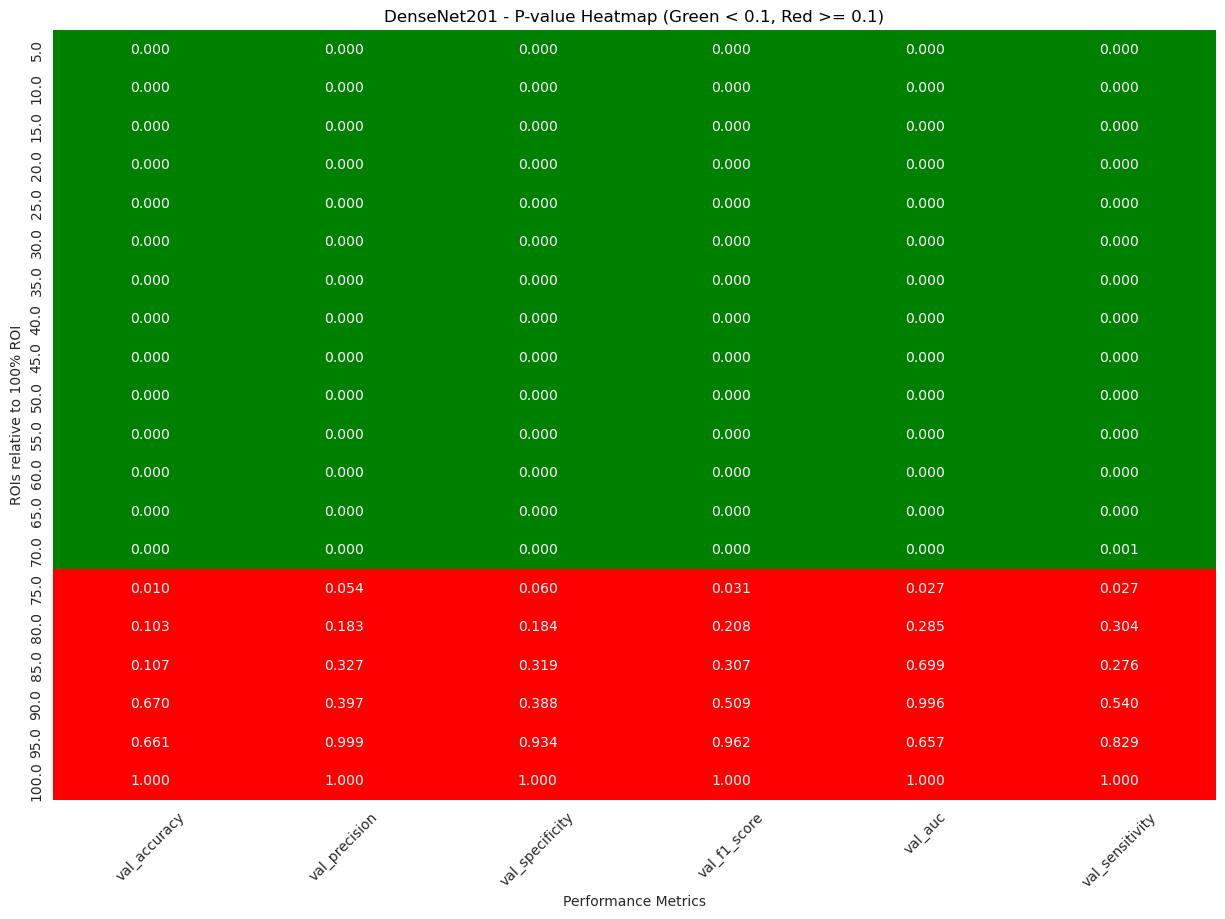

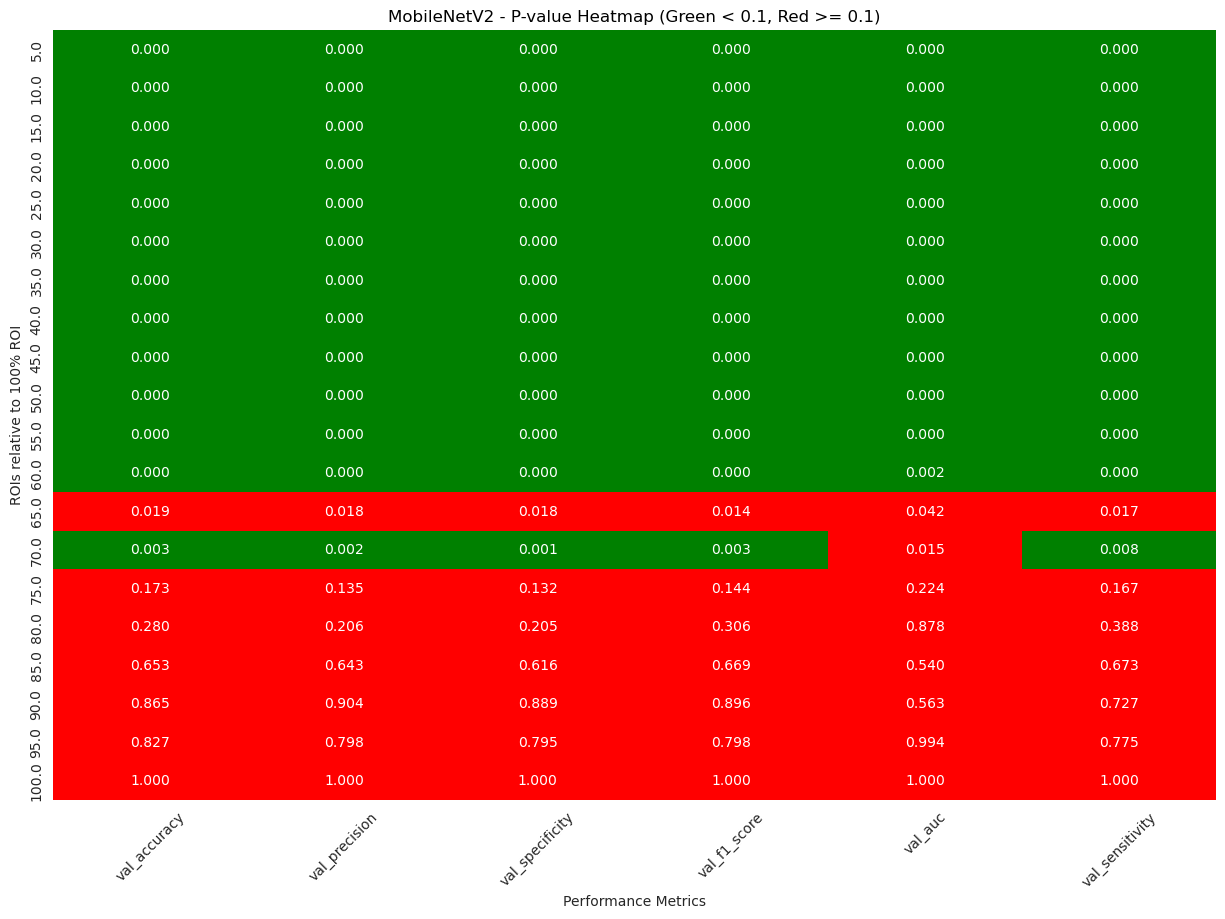

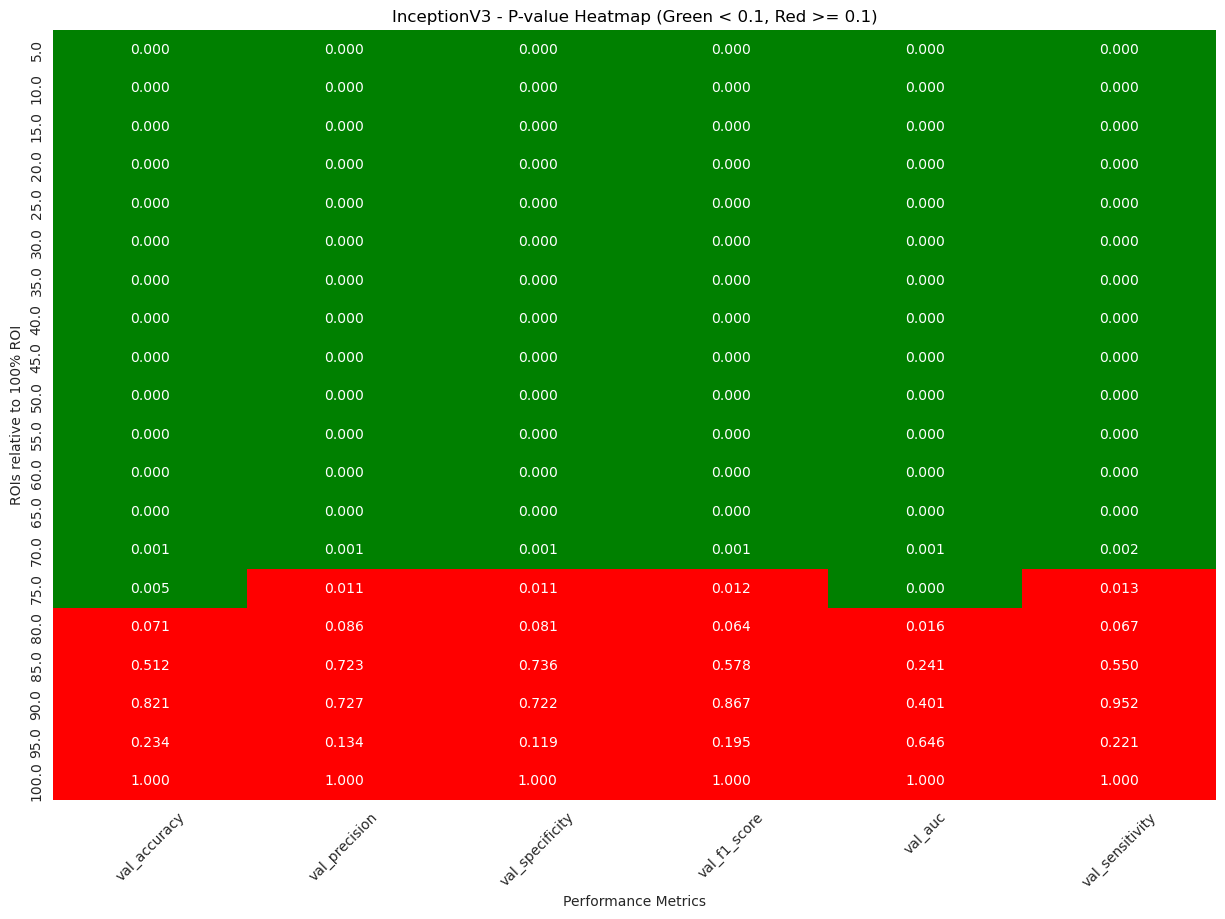

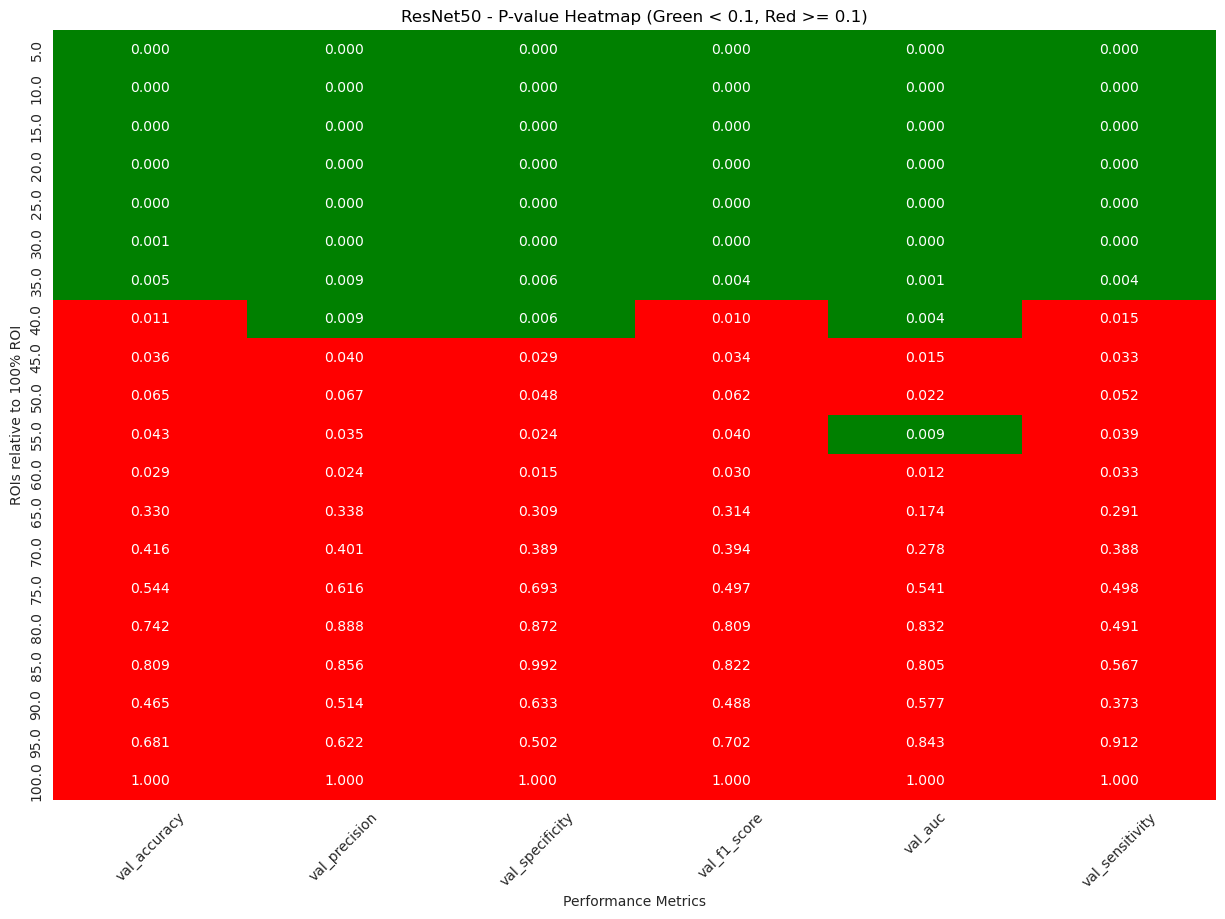

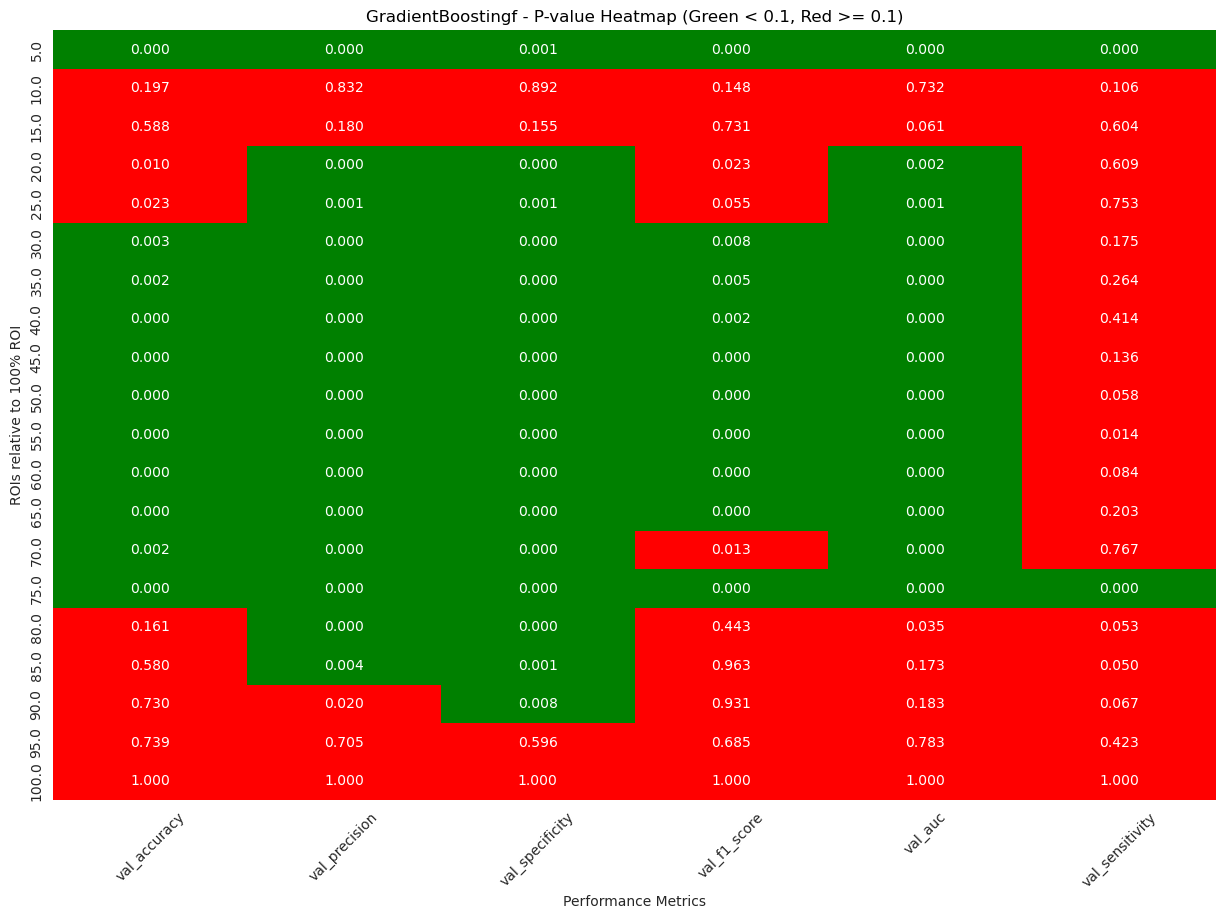

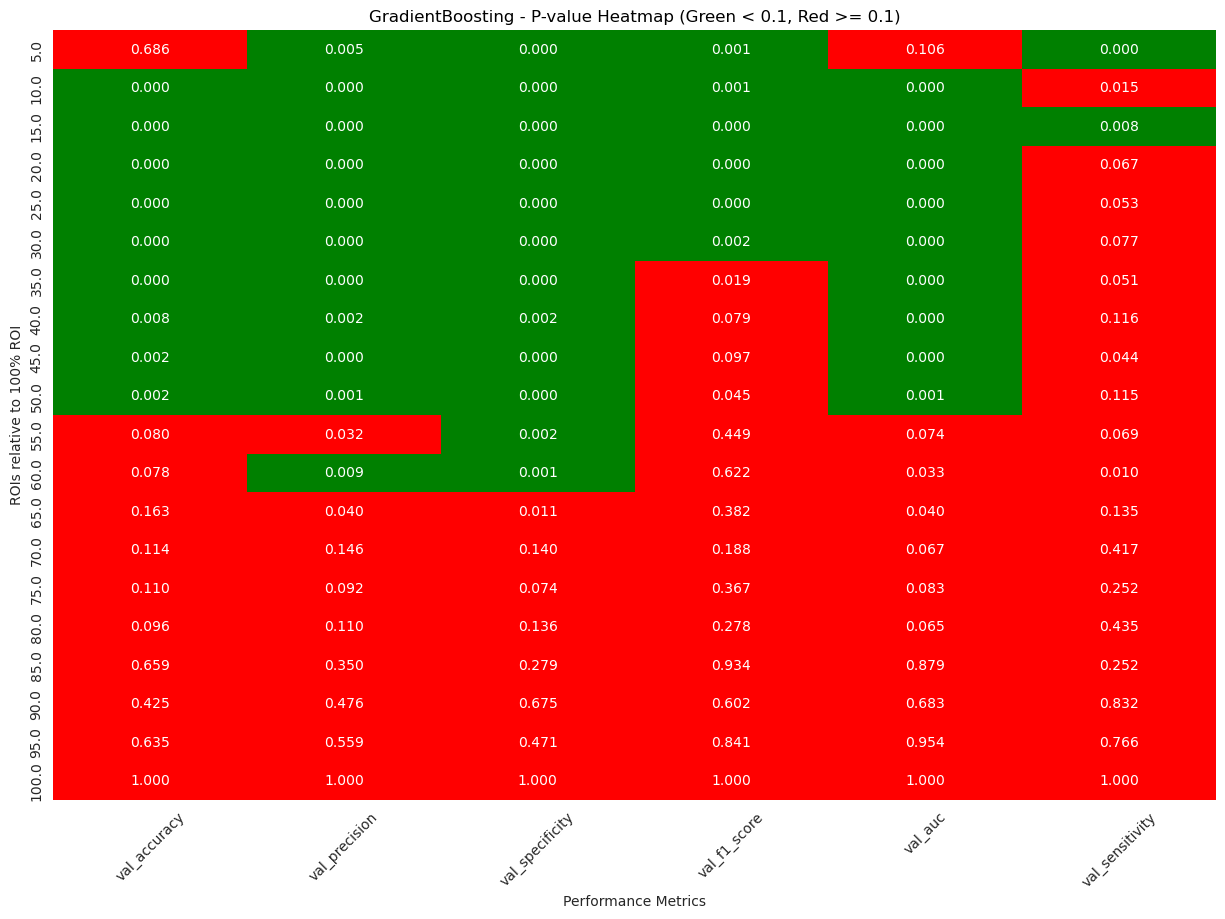

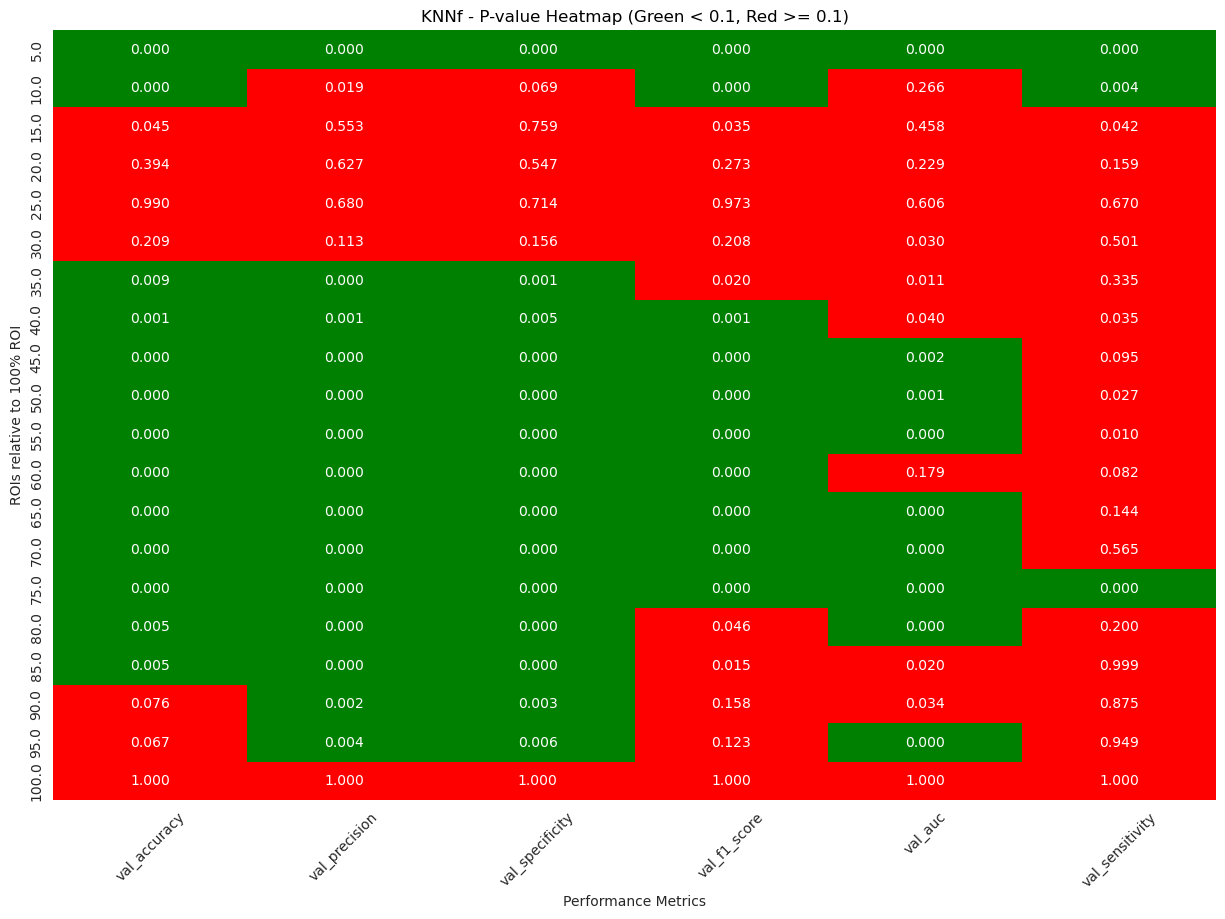

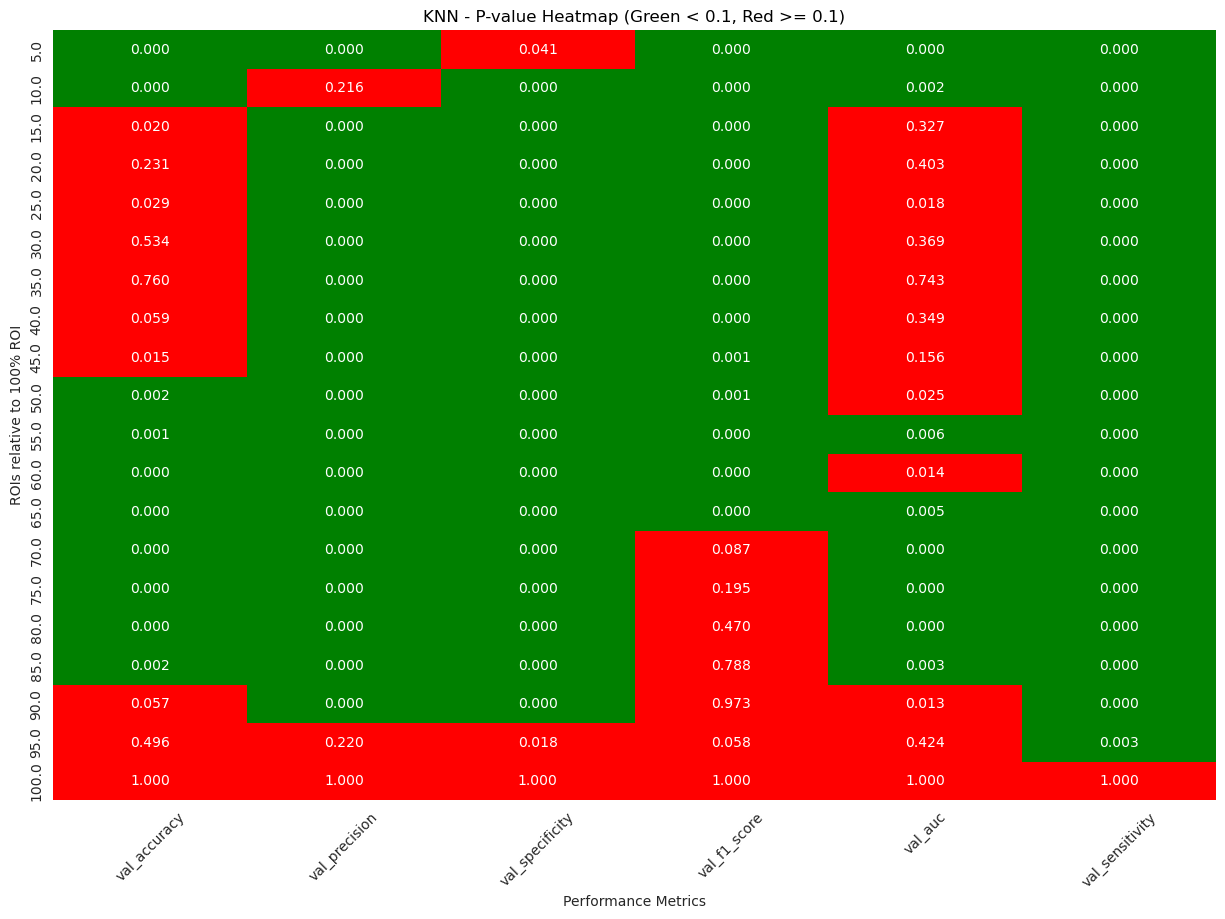

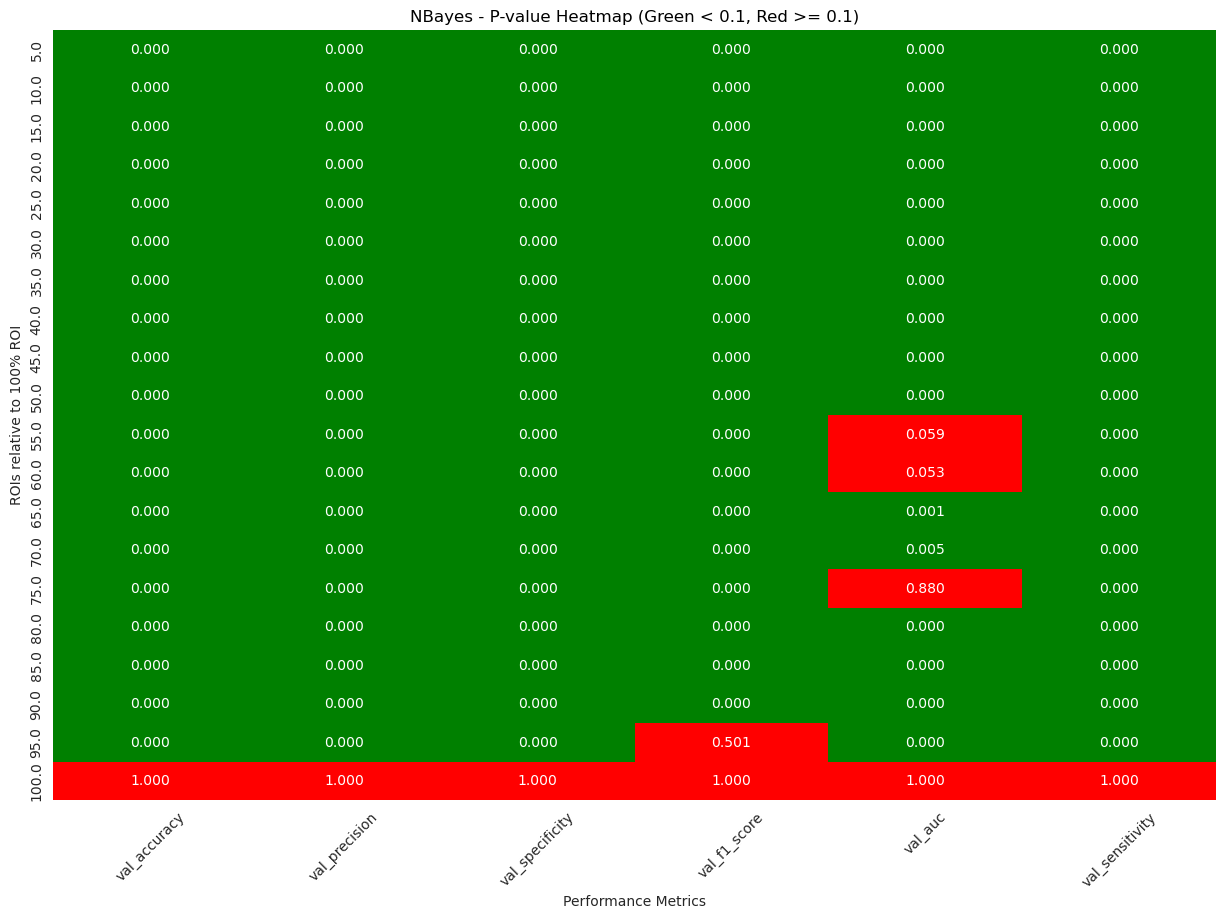

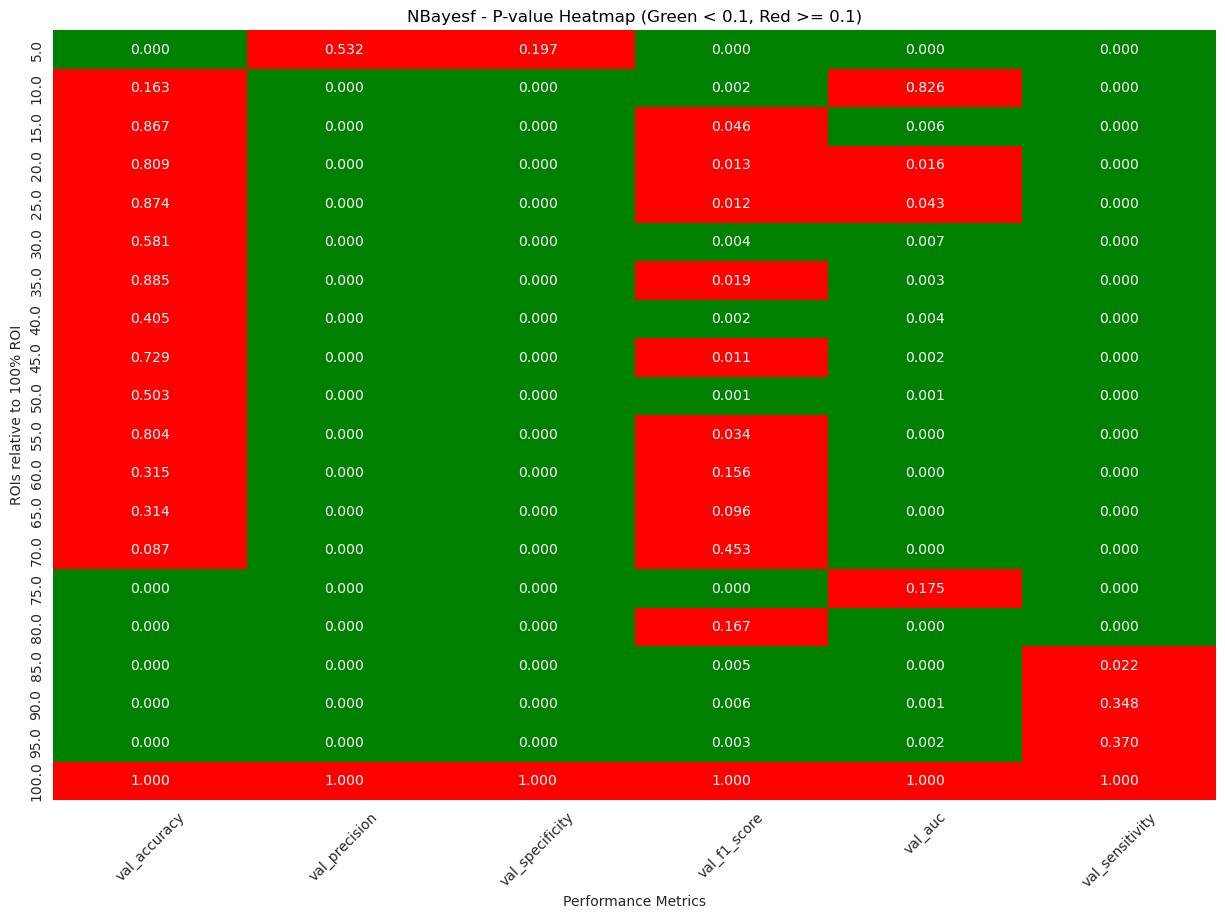

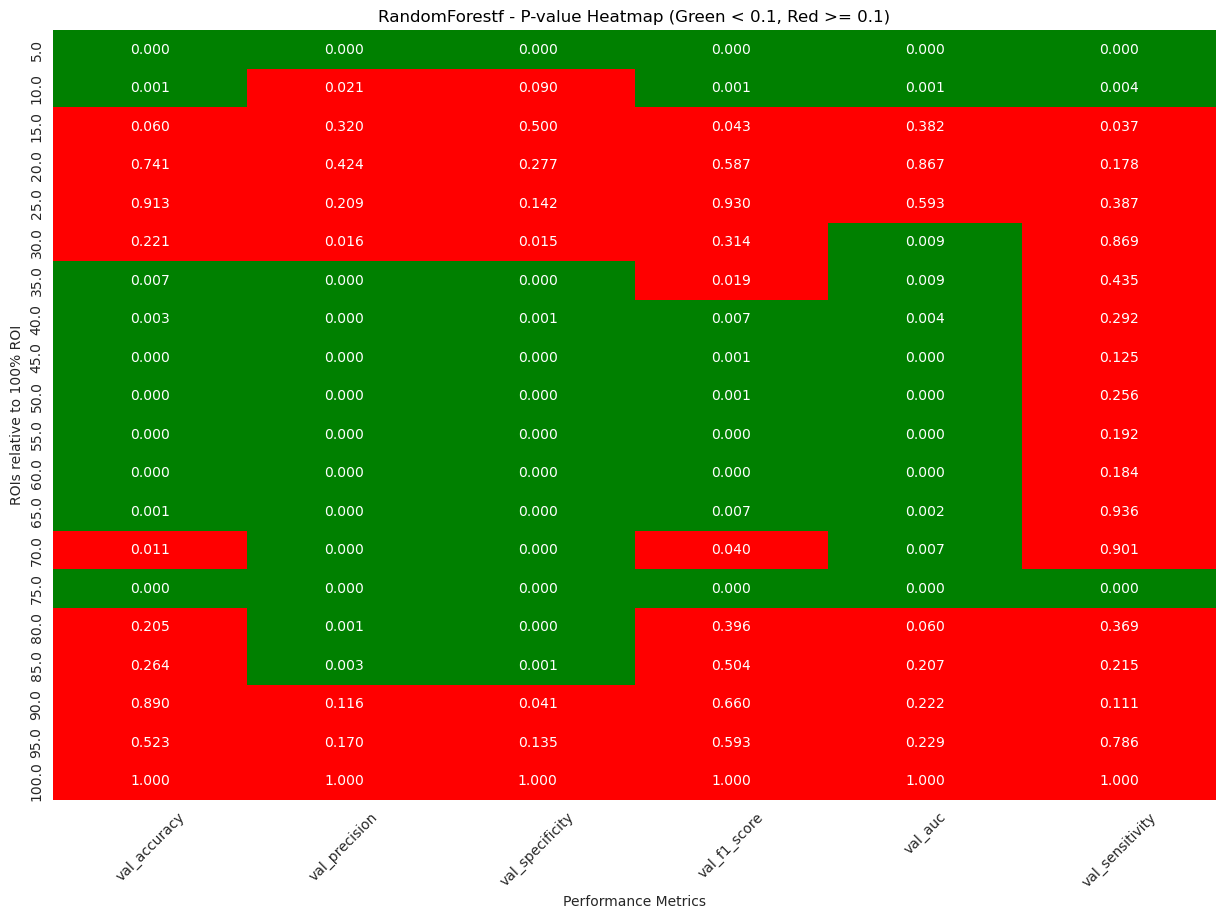

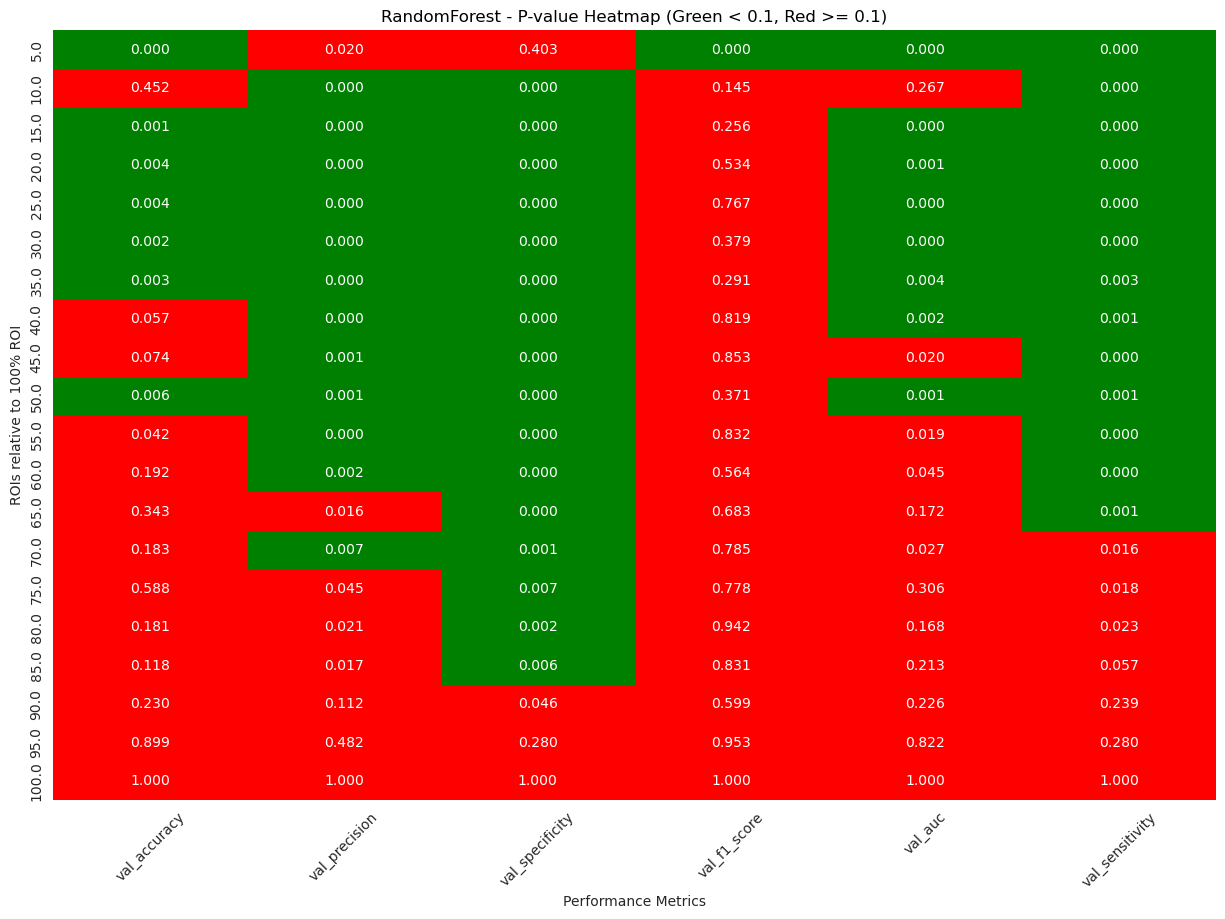

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Load the p_values data
result_p_values = pd.read_csv(output / "p_values.csv")

# Define a custom colormap: green for significant (p < 0.01), red for not significant
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green'])

# Iterate over each network to plot heatmaps
for network in result_p_values['network'].unique():
    network_data = result_p_values[result_p_values['network'] == network]
    network_data = network_data.pivot(index='roi', columns='column', values='p_value')
    network_data = network_data[COLUMNS]
    network_data = network_data.round(3)

    # Define a binary matrix for significance
    significant = (network_data < 0.01).astype(int)

    plt.figure(figsize=(15, 10))
    sns.heatmap(significant, annot=network_data.values, fmt=".3f", cmap=cmap, cbar=False)
    plt.title(f"{network} - P-value Heatmap (Green < 0.1, Red >= 0.1)")
    plt.xticks(rotation=45)
    plt.xlabel("Performance Metrics")
    plt.ylabel("ROIs relative to 100% ROI")

    # Ensure the output directory exists
    output_dir = output 
    plt.savefig(output_dir / f"{network}.png")
    plt.show()


In [23]:
import pandas as pd

# Função para calcular a diferença de médias entre uma ROI específica e 100%
def calculate_effect(main_pd, roi):
    effect_df = pd.DataFrame()
    for network in main_pd['network'].unique():
        network_data = main_pd[main_pd['network'] == network]
        roi_data = network_data[network_data['dataset'] == roi]
        roi_100_data = network_data[network_data['dataset'] == 100]
        
        for column in COLUMNS:
            effect_size = roi_data[column].mean() - roi_100_data[column].mean()
            effect_df = effect_df._append({'network': network, 'roi': roi, 'column': column, 'effect_size': effect_size}, ignore_index=True)
            
    return effect_df

effect_df = pd.DataFrame()
for roi in result['dataset'].unique():
    effect_df = pd.concat([effect_df, calculate_effect(result, roi)], ignore_index=True)

# Salvar o efeito das ROIs
effect_df.to_csv(output / "roi_effect_sizes.csv", index=False)


import numpy as np

# Função para calcular Cohen's d entre uma ROI específica e 100%
def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    pooled_std = np.sqrt(((len(group1) - 1) * group1.std()**2 + (len(group2) - 1) * group2.std()**2) / (len(group1) + len(group2) - 2))
    return diff / pooled_std

def calculate_cohens_d(main_pd, roi):
    cohen_df = pd.DataFrame()
    for network in main_pd['network'].unique():
        network_data = main_pd[main_pd['network'] == network]
        roi_data = network_data[network_data['dataset'] == roi]
        roi_100_data = network_data[network_data['dataset'] == 100]
        
        for column in COLUMNS:
            d = cohen_d(roi_data[column], roi_100_data[column])
            cohen_df = cohen_df._append({'network': network, 'roi': roi, 'column': column, 'cohen_d': d}, ignore_index=True)
            
    return cohen_df

cohen_df = pd.DataFrame()
for roi in result['dataset'].unique():
    cohen_df = pd.concat([cohen_df, calculate_cohens_d(result, roi)], ignore_index=True)

# Salvar Cohen's d
cohen_df.to_csv(output / "cohens_d.csv", index=False)



/tmp/ipykernel_63906/3455319325.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric],


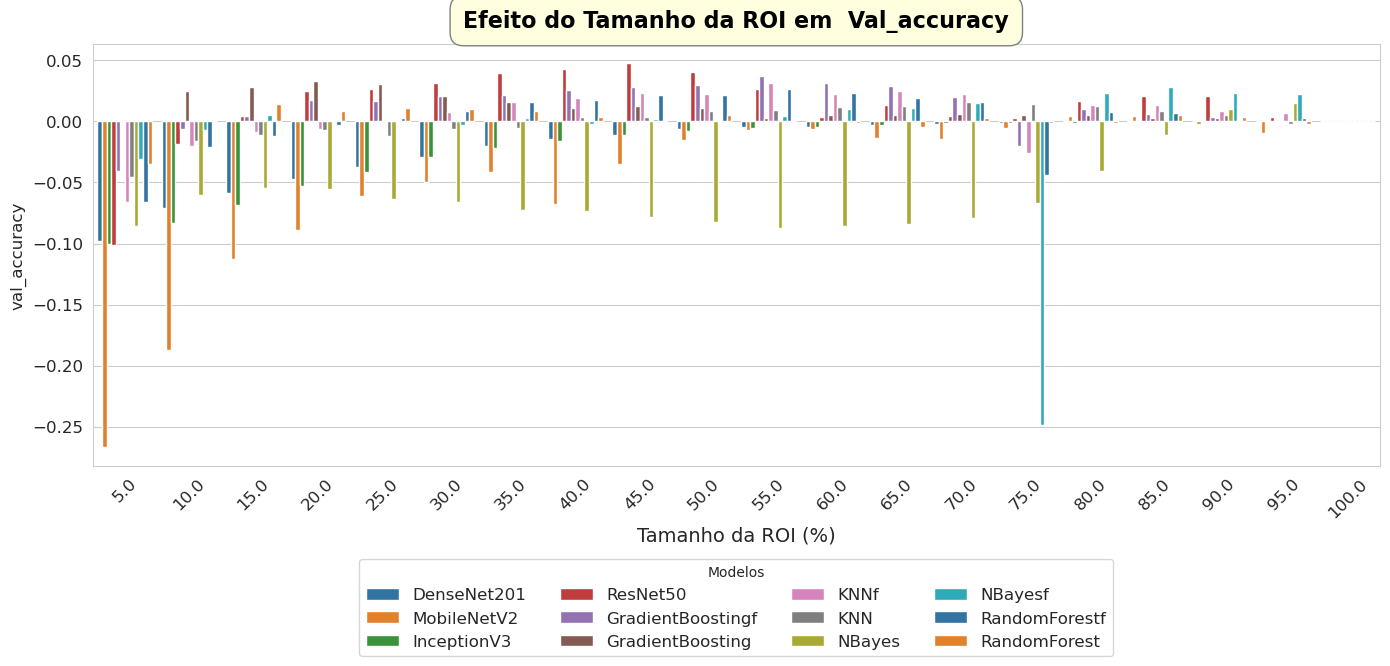

/tmp/ipykernel_63906/3455319325.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric],


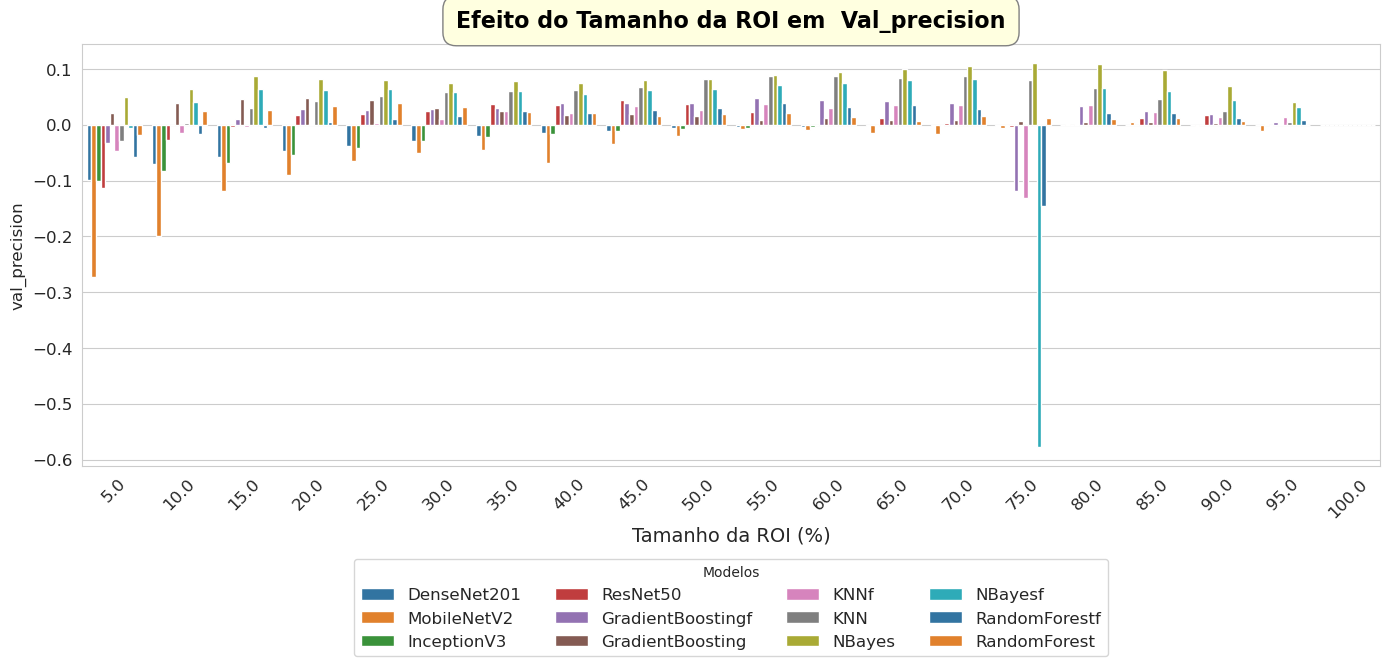

/tmp/ipykernel_63906/3455319325.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric],


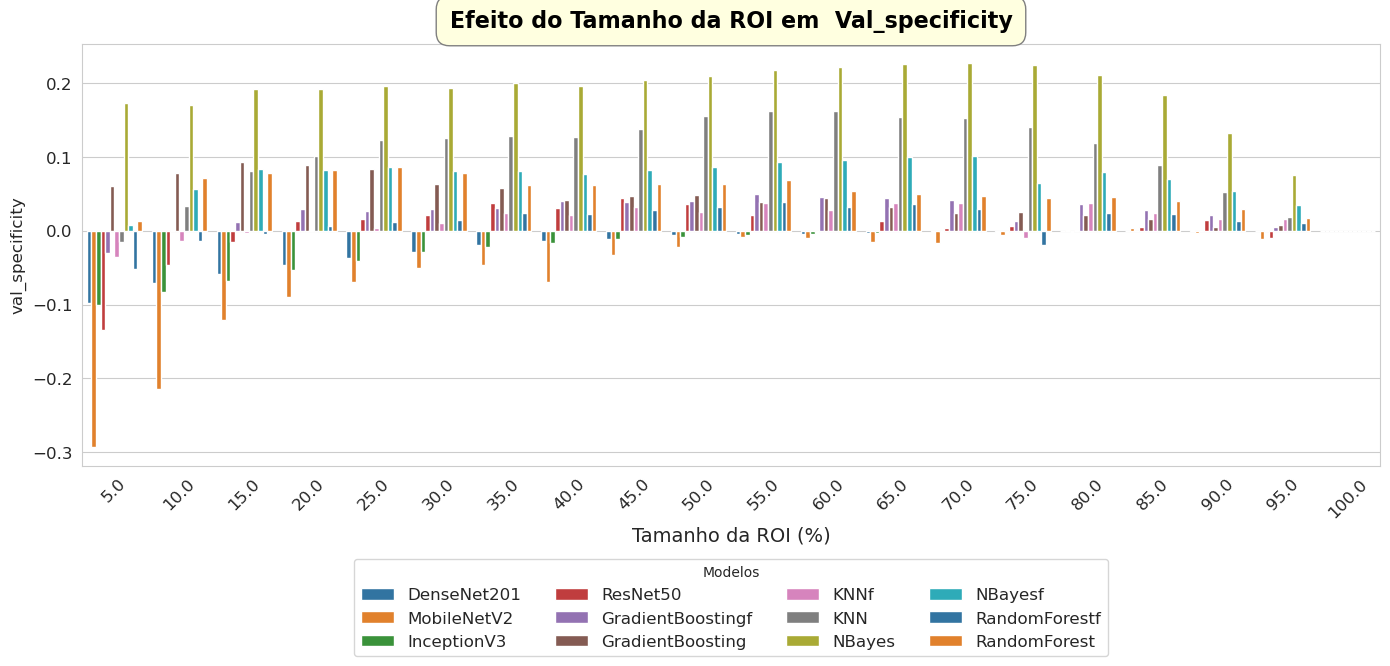

/tmp/ipykernel_63906/3455319325.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric],


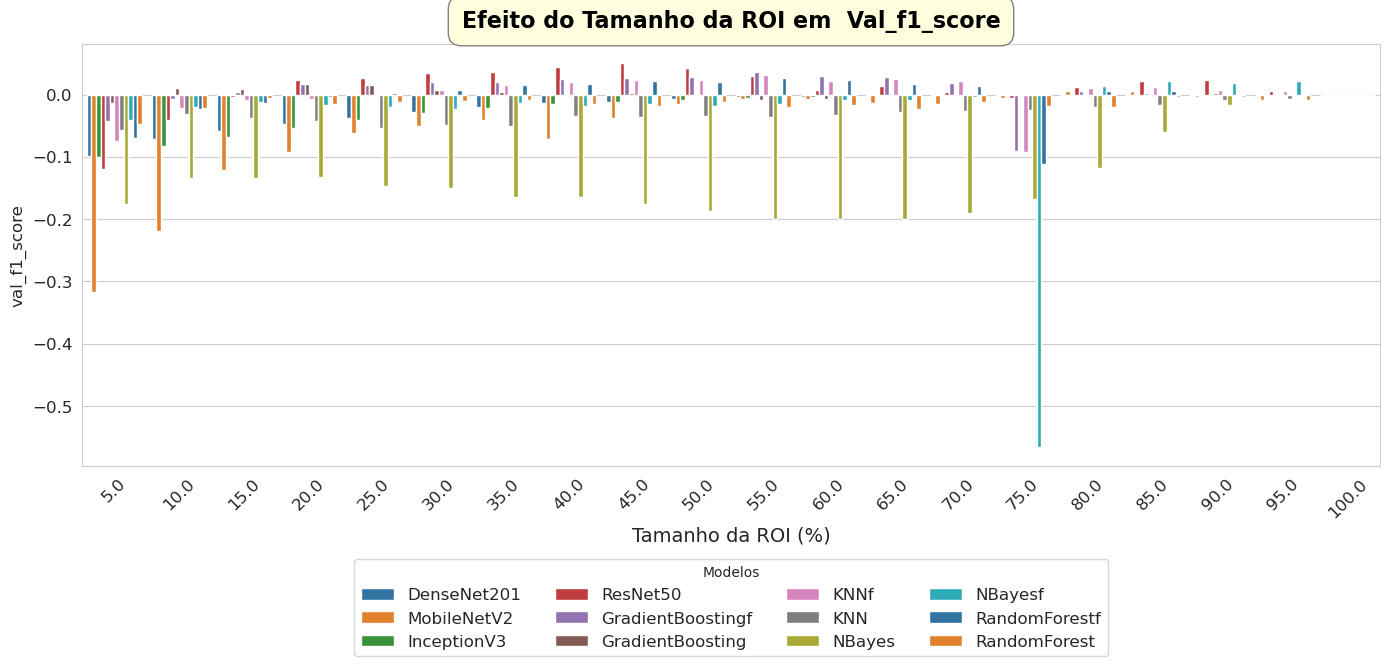

/tmp/ipykernel_63906/3455319325.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric],


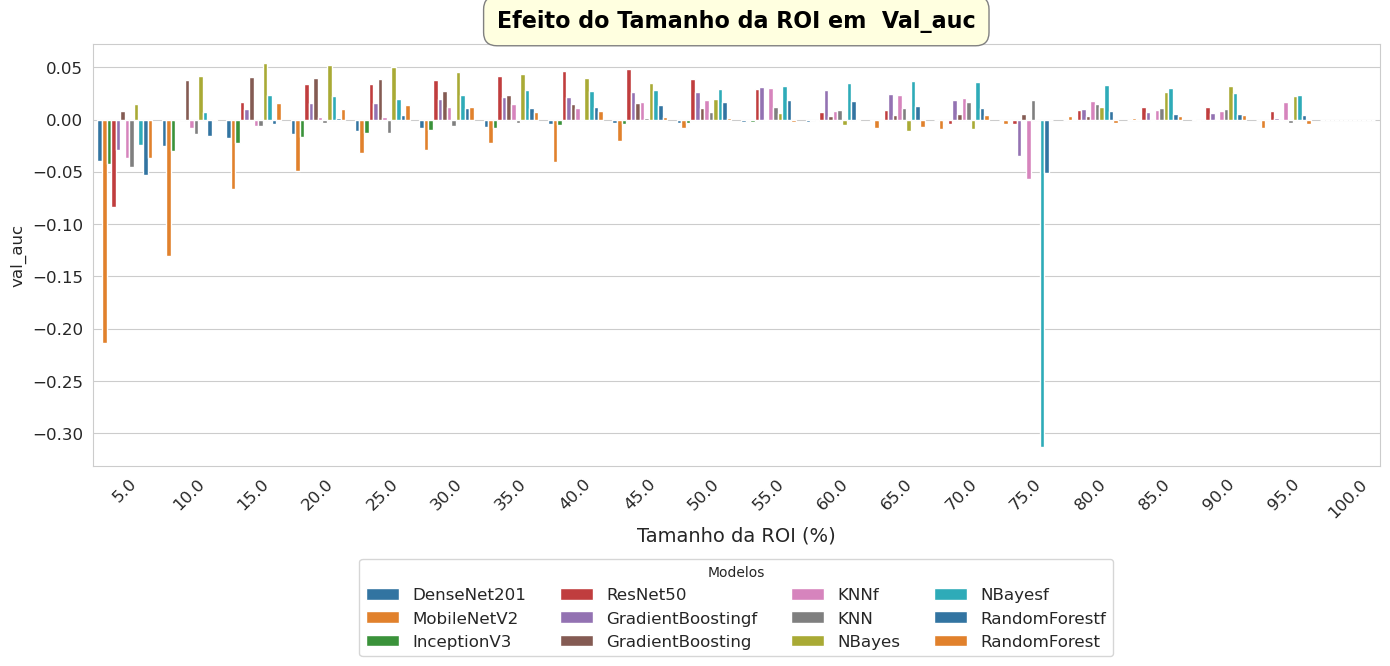

/tmp/ipykernel_63906/3455319325.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric],


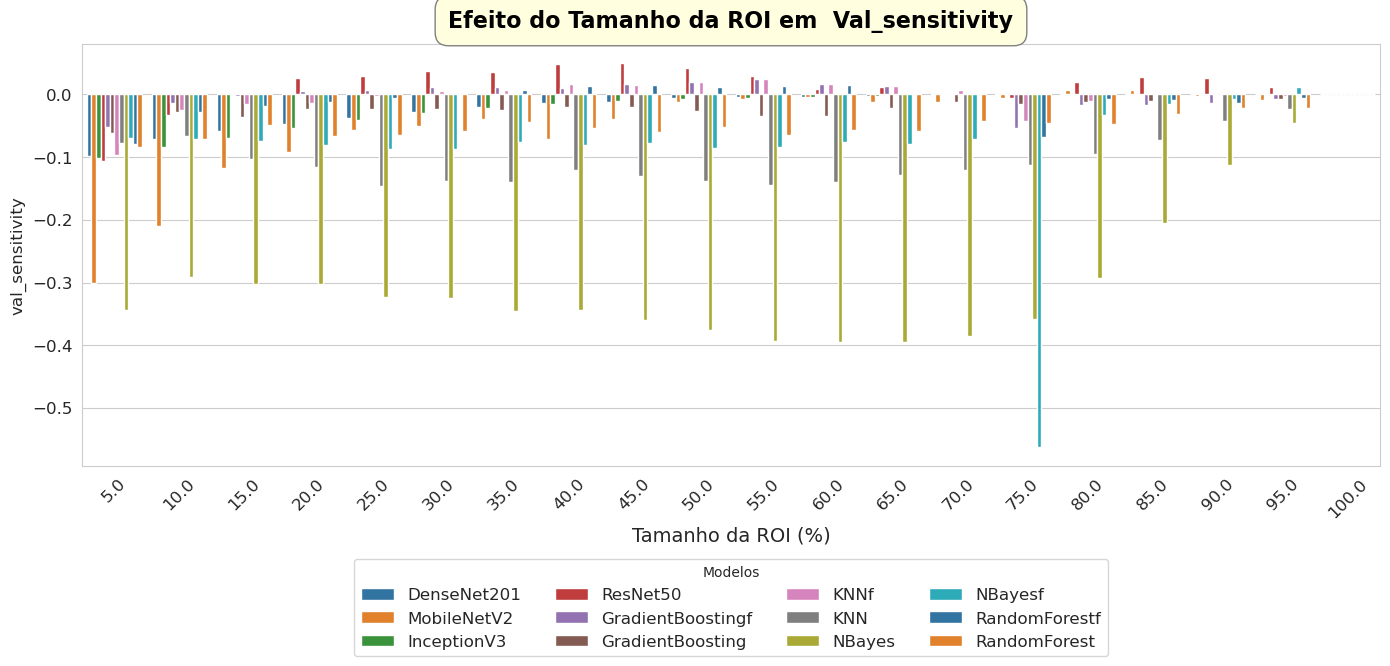

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Carregar os dados do ROI Effect
effect_df = pd.read_csv(output / "roi_effect_sizes.csv")

# Função para plotar o efeito das ROIs para cada métrica e modelo
def plot_roi_effect(effect_df, metric, legend_columns=4):
    plt.figure(figsize=(14, 7))  # Aumentar o tamanho da figura
    sns.set_style("whitegrid")
    
    # Usar uma paleta de cores distinta
    palette = sns.color_palette("tab10", n_colors=len(effect_df['network'].unique()))

    # Aumentar a largura das barras
    sns.barplot(x='roi', y='effect_size', hue='network', data=effect_df[effect_df['column'] == metric], 
                palette=palette, dodge=True, ci=None, width=0.85)  # Largura das barras aumentada para 0.85

    # Estilo do título igual ao usado no boxplot
    plt.title(f"Efeito do Tamanho da ROI em  {metric.capitalize()}", fontsize=16, fontweight='bold',
              pad=12, color='black', backgroundcolor='lightgray',
              bbox=dict(facecolor='lightyellow', edgecolor='gray', boxstyle='round,pad=0.6'))

    # Melhorar os rótulos dos eixos
    plt.xlabel("Tamanho da ROI (%)", fontsize=14)
    plt.ylabel(f"{metric}", fontsize=12)
    
    # Ajustar os ticks para melhor legibilidade
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Ajustar a legenda para ser exibida em duas linhas com colunas configuráveis
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, bbox_to_anchor=(0.5, -0.2), loc='upper center', 
               fontsize=12, ncol=legend_columns, title='Modelos')

    # Ajustar layout para evitar sobreposição
    plt.tight_layout()

    # Salvar o gráfico com alta resolução
    plt.savefig(output / f"roi_effect_{metric}.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

# Plotar para cada métrica em COLUMNS
for metric in COLUMNS:
    plot_roi_effect(effect_df, metric, legend_columns=4)  # Defina o número de colunas da legenda


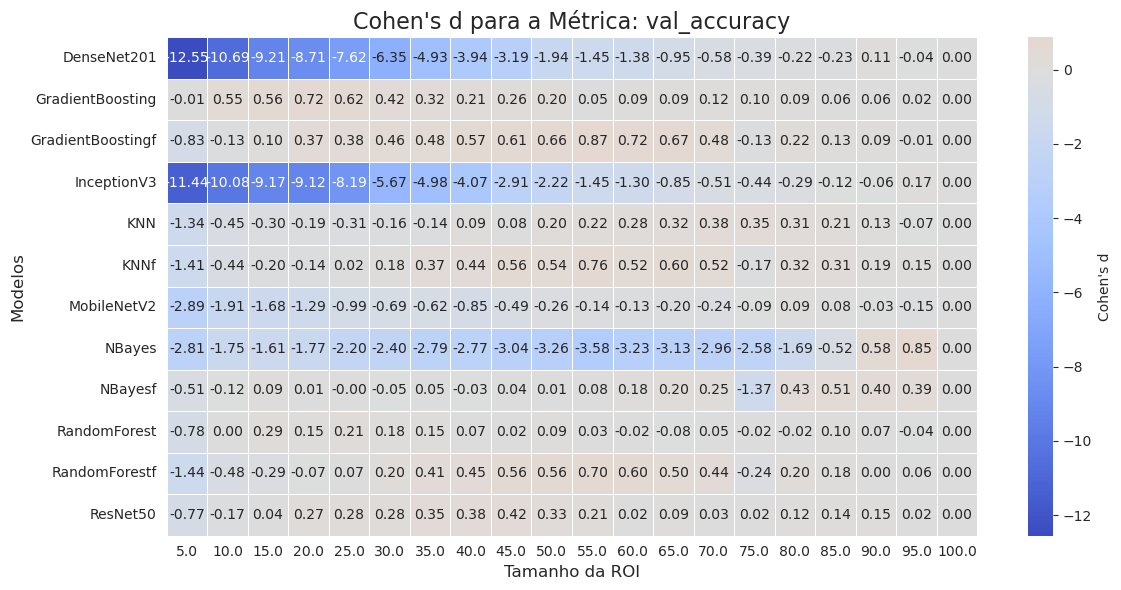

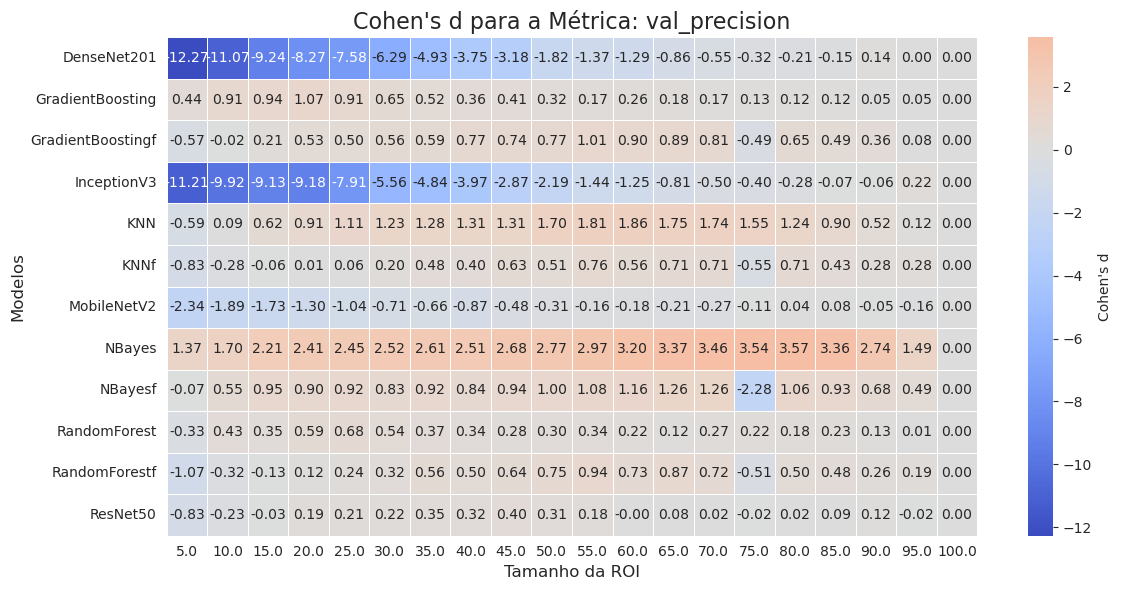

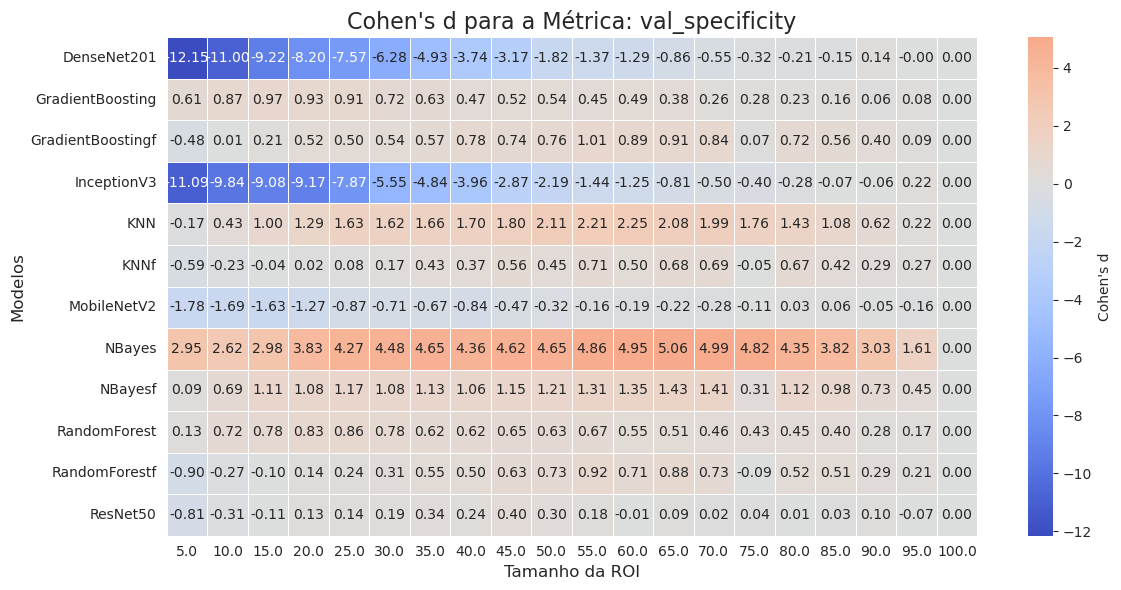

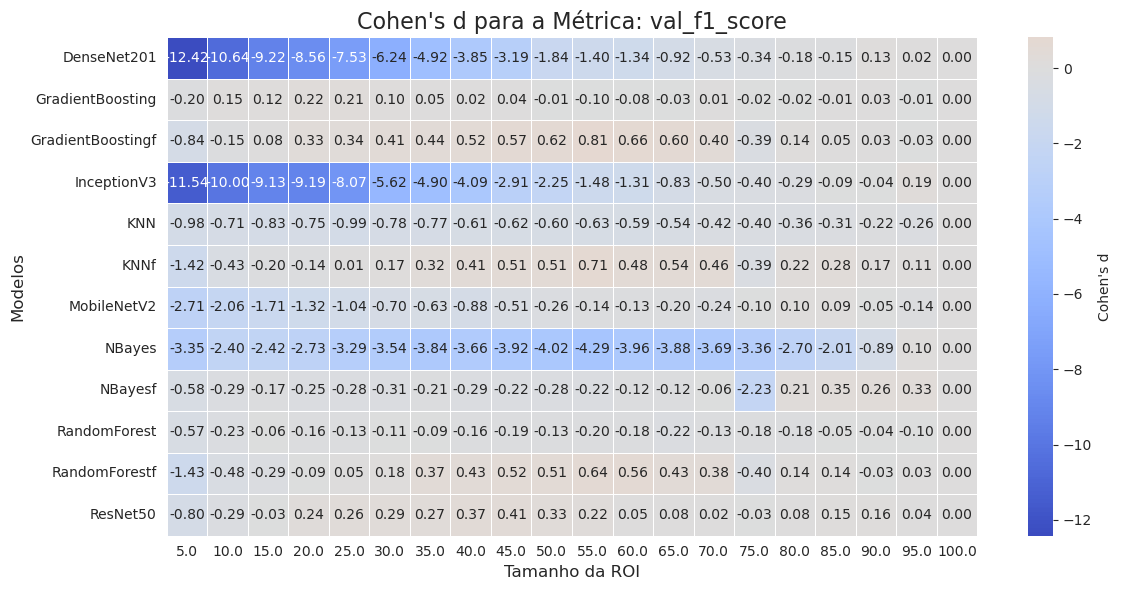

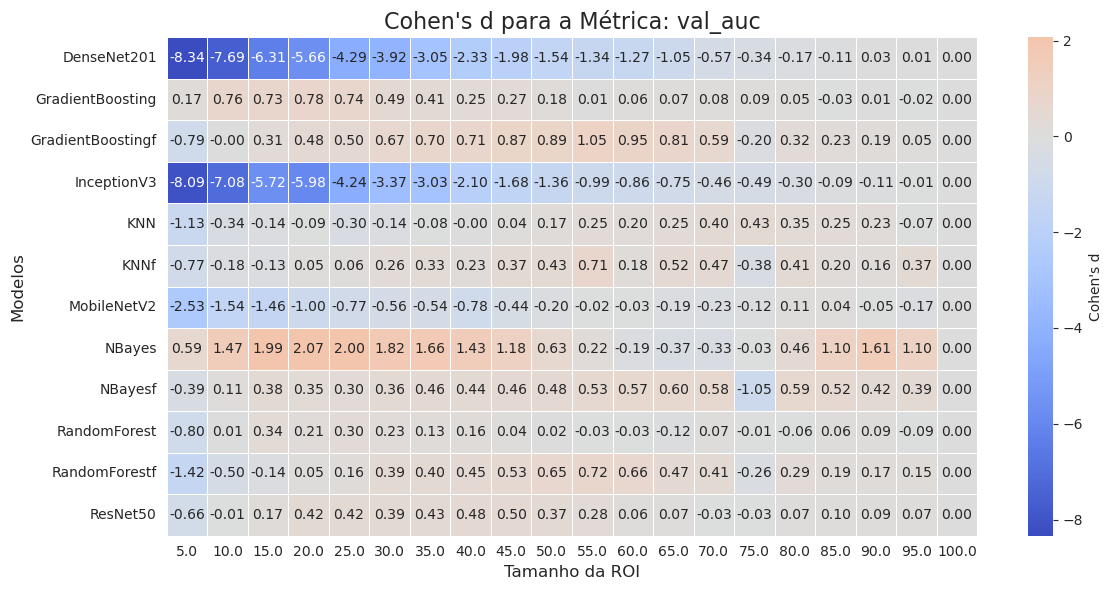

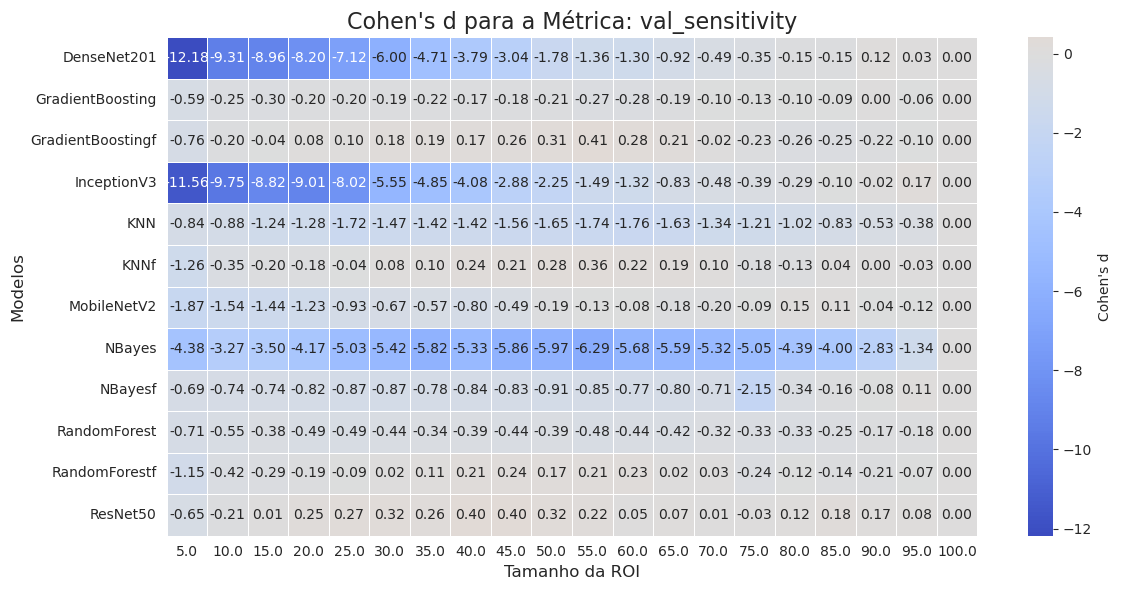

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Carregar os dados de Cohen's d
cohen_df = pd.read_csv(output / "cohens_d.csv")

# Plotar o Cohen's d para cada métrica e modelo
def plot_cohens_d(cohen_df, metric):
    plt.figure(figsize=(12, 6))
    
    # Pivotar os dados para exibir em um heatmap
    pivot_df = cohen_df[cohen_df['column'] == metric].pivot(index='network', columns='roi', values='cohen_d')
    
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Cohen\'s d'})
    
    plt.title(f"Cohen's d para a Métrica: {metric}", fontsize=16)
    plt.xlabel("Tamanho da ROI", fontsize=12)
    plt.ylabel("Modelos", fontsize=12)
    
    plt.tight_layout()
    
    # Salvar o gráfico
    plt.savefig(output / f"cohens_d_{metric}.png", dpi=300)
    plt.show()

# Plotar para cada métrica em COLUMNS
for metric in COLUMNS:
    plot_cohens_d(cohen_df, metric)


MovieWriter imagemagick unavailable; using Pillow instead.


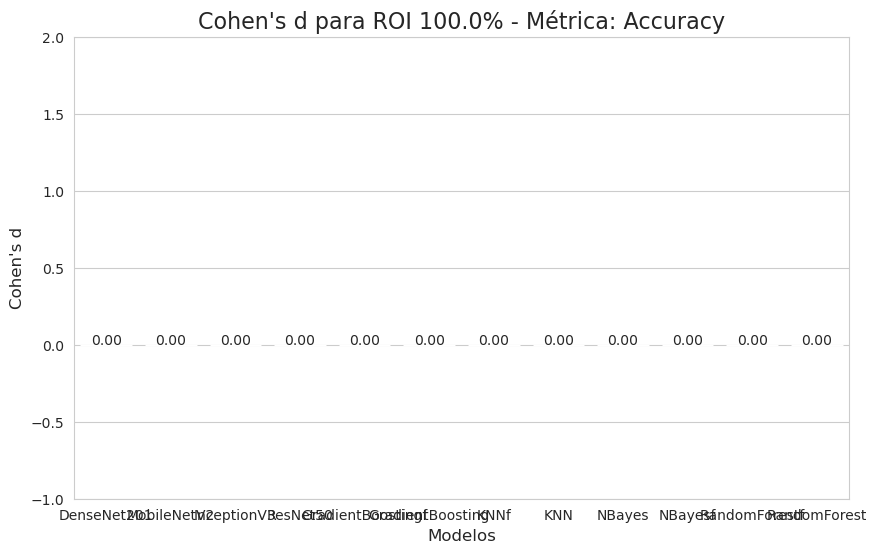

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.animation import FuncAnimation

# Carregar os dados de Cohen's d
cohen_df = pd.read_csv(output / "cohens_d.csv")

# Filtrar para a métrica de interesse (val_accuracy)
cohen_accuracy_df = cohen_df[cohen_df['column'] == 'val_accuracy']

# Configurações para a animação
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# Função para atualizar o gráfico em cada frame
def update(roi):
    plt.cla()  # Limpar o gráfico anterior
    data = cohen_accuracy_df[cohen_accuracy_df['roi'] == roi]
    
    # Plotar o Cohen's d para a ROI atual
    sns.barplot(x='network', y='cohen_d', data=data, palette='coolwarm', ax=ax)
    
    # Adicionar título e rótulos
    ax.set_title(f"Cohen's d para ROI {roi}% - Métrica: Accuracy", fontsize=16)
    ax.set_ylabel("Cohen's d", fontsize=12)
    ax.set_xlabel("Modelos", fontsize=12)
    
    # Limitar o eixo y para consistência
    ax.set_ylim(-1, 2)
    
    # Adicionar valor do Cohen's d nas barras
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10)

# Lista de ROIs para a animação
rois = sorted(cohen_accuracy_df['roi'].unique())

# Criar a animação
ani = FuncAnimation(fig, update, frames=rois, repeat=False)

# Salvar como GIF
ani.save(output / "cohens_d_accuracy_animation.gif", writer='imagemagick', fps=1)

# Mostrar o GIF (para visualização no notebook, se aplicável)
plt.show()


In [27]:
# Importar as bibliotecas necessárias
import pandas as pd
order = ['val_accuracy', 'val_precision', 'val_specificity', 'val_f1_score', 'val_auc', 'val_sensitivity']
# Adicionar uma coluna que indica se a hipótese nula foi rejeitada
result_p_values['Rejected'] = result_p_values['h'].apply(lambda x: 1 if x == 0 else 0)

# Calcular a taxa de rejeição para cada combinação de rede e ROI
rejection_rates = result_p_values.groupby(['network', 'roi']).agg(
    Total_Tests=pd.NamedAgg(column='h', aggfunc='count'),
    Total_Rejections=pd.NamedAgg(column='Rejected', aggfunc='sum')
).reset_index()

rejection_rates['Rejection_Rate'] = rejection_rates['Total_Rejections'] / rejection_rates['Total_Tests']

# Identificar a menor ROI para cada rede com uma taxa de rejeição igual a 0 (ou seja, sem impacto significativo)
min_acceptable_rois = rejection_rates[rejection_rates['Rejection_Rate'] == 0].groupby('network').agg(
    Min_ROI=pd.NamedAgg(column='roi', aggfunc='min')
).reset_index()

# Filtrar `result_p_values` para essas combinações de rede e ROI
optimal_data = result_p_values[
    result_p_values.apply(lambda x: (x['network'], x['roi']) in list(zip(min_acceptable_rois['network'], min_acceptable_rois['Min_ROI'])), axis=1)
]

# Pivotar o DataFrame para preparar os dados da tabela
pivot_df = optimal_data.pivot_table(index=['network', 'roi'], columns='column', values='p_value', aggfunc='first').reset_index()

# Preparar os dados da tabela
columns = ['Model', 'ROI'] + order
cell_text = []
for _, row in pivot_df.iterrows():
    roi_with_percent = f"{row['roi']}%"
    row_data = [row['network'], roi_with_percent] + [f"{row[metric]:.3f}" for metric in pivot_df.columns if metric not in ['network', 'roi']]
    cell_text.append(row_data)

# Salvar a nova tabela de taxas de rejeição
rejection_rates.to_csv(output / "rejection_rates.csv", index=False)


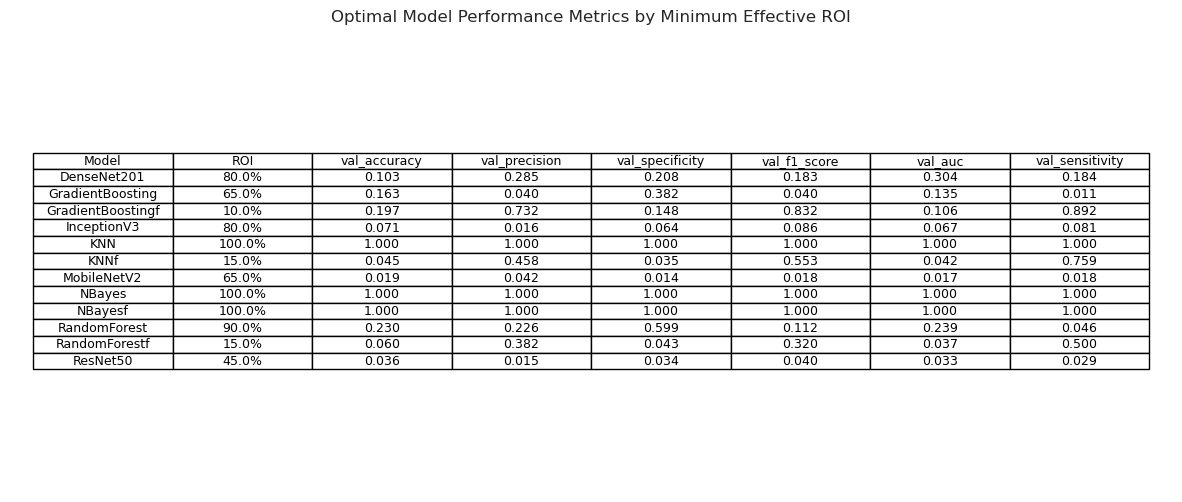

In [28]:
import matplotlib.pyplot as plt

# Assume cell_text and columns are already prepared and include a 'Rejected' indicator
# Example: cell_text might include rows like [network, roi, val_accuracy (p-value), rejected_indicator, ...]

# Create the figure and axis with higher DPI for better resolution
fig, ax = plt.subplots(figsize=(15, 6))
ax.axis('tight')
ax.axis('off')

# Set font size globally for the table
plt.rcParams.update({'font.size': 10, 'text.color': 'black'})

# Create the table
the_table = plt.table(cellText=[row for row in cell_text],  # Excluding the 'Rejected' column from display
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.12] * len(columns))


    

# Calculate the middle of the attributes columns and draw a vertical line
num_attributes = len(columns) - 1
mid_index = num_attributes // 2 + 0.5 if num_attributes % 2 == 0 else num_attributes // 2 + 1
x_pos = (mid_index + 0.5) / num_attributes

# Draw the line splitting attributes into two groups
plt.axvline(x=x_pos, color='black', linestyle='-', linewidth=1)

plt.title('Optimal Model Performance Metrics by Minimum Effective ROI')
plt.show()

# Save the figure
fig.savefig('hyphotesis_table.png')
